In [ ]:
# @title all in one
import os
import pandas as pd
import numpy as np
import re
import html
import sys
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"

import torch
from transformers import MarianMTModel, MarianTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import StratifiedGroupKFold

def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_level_basic(text):
    if pd.isnull(text):
        return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'－', '-', text).replace('—', '-').replace('–', '-')
    text = re.sub(r'([a-zA-Z])\*([a-zA-Z])', r'\1 \2', text)
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_level_medium(text):
    text = clean_level_basic(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_level_advanced(text):
    text = clean_level_medium(text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    words = [lemmatizer.lemmatize(word, pos='n') for word in words]
    return ' '.join(words)

SRC_LANG = "en"
INTER_LANG = "es"
TOLERANCIA = 0.8

MAX_TOKENS_PER_CHUNK = 450
CHUNK_OVERLAP = 50

MIN_TEXT_LENGTH = 50
MIN_SEMANTIC_SIMILARITY = 0.70
MIN_LENGTH_RATIO = 0.60
MAX_LENGTH_RATIO = 1.50
MAX_AUGMENTATION_RATIO = 2.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Dispositivo: {device}\n")

def load_translation_models(src_lang="en", tgt_lang="es"):
    model_name_forward = f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}"
    model_name_backward = f"Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}"

    print(f"   [INFO] {model_name_forward}")
    tok_forward = MarianTokenizer.from_pretrained(model_name_forward)
    model_forward = MarianMTModel.from_pretrained(model_name_forward).to(device)

    print(f"   [INFO] {model_name_backward}")
    tok_backward = MarianTokenizer.from_pretrained(model_name_backward)
    model_backward = MarianMTModel.from_pretrained(model_name_backward).to(device)

    return (tok_forward, model_forward), (tok_backward, model_backward)

print("   [INFO] Modelo de embeddings semanticos...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
if torch.cuda.is_available():
    embedding_model = embedding_model.to(device)

print("\n[SUCCESS] Todos los modelos cargados\n")

def estimate_tokens(text):
    return int(len(text.split()) * 1.33)

def split_text_into_chunks(text, max_tokens=450, overlap_words=50):
    words = text.split()

    if estimate_tokens(text) <= max_tokens:
        return [text]

    words_per_chunk = int(max_tokens / 1.33)

    chunks = []
    i = 0

    while i < len(words):
        chunk_words = words[i:i + words_per_chunk]
        chunk_text = ' '.join(chunk_words)

        chunks.append(chunk_text)

        i += words_per_chunk - overlap_words

        if i > len(words) - overlap_words:
            break

    return chunks

def merge_chunks(chunks):
    if len(chunks) == 1:
        return chunks[0]

    merged = ' '.join(chunks)

    merged = re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', merged)

    merged = re.sub(r'\s+', ' ', merged)

    return merged.strip()

def translate_batch(texts, tokenizer, model, batch_size=8):
    all_translations = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            translated = model.generate(**inputs, max_new_tokens=512)

        batch_translations = [
            tokenizer.decode(t, skip_special_tokens=True)
            for t in translated
        ]
        all_translations.extend(batch_translations)

    return all_translations

def back_translate_with_chunking(text, model_fw, model_bw):
    tok_fw, mod_fw = model_fw
    tok_bw, mod_bw = model_bw

    chunks = split_text_into_chunks(text, MAX_TOKENS_PER_CHUNK, CHUNK_OVERLAP)

    if len(chunks) == 1:
        mid_text = translate_batch([text], tok_fw, mod_fw)[0]
        back_text = translate_batch([mid_text], tok_bw, mod_bw)[0]
        return back_text, 1, 'direct'

    translated_chunks = []

    for chunk in chunks:
        mid_chunk = translate_batch([chunk], tok_fw, mod_fw)[0]
        back_chunk = translate_batch([mid_chunk], tok_bw, mod_bw)[0]
        translated_chunks.append(back_chunk)

    final_text = merge_chunks(translated_chunks)

    return final_text, len(chunks), 'chunked'

def semantic_similarity(text1, text2):
    with torch.no_grad():
        embeddings = embedding_model.encode([text1, text2], convert_to_tensor=True)
        similarity = cosine_similarity(
            embeddings[0].cpu().reshape(1, -1),
            embeddings[1].cpu().reshape(1, -1)
        )[0][0]
    return float(similarity)

def extract_numbers(text):
    return set(re.findall(r'\b\d+\b', text))

def extract_tech_keywords(text):
    tech_terms = [
        'python', 'java', 'javascript', 'sql', 'c++', 'c#', 'php', 'ruby', 'go',
        'typescript', 'swift', 'kotlin', 'r', 'matlab', 'scala', 'rust', 'perl',
        'react', 'angular', 'vue', 'django', 'flask', 'spring', 'node', 'express',
        'tensorflow', 'pytorch', 'keras', 'scikit', 'pandas', 'numpy', 'scipy',
        'jquery', 'bootstrap', 'tailwind',
        'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins', 'git', 'github',
        'gitlab', 'terraform', 'ansible', 'vagrant', 'circleci',
        'mysql', 'postgresql', 'mongodb', 'redis', 'oracle', 'cassandra',
        'elasticsearch', 'dynamodb', 'sqlite', 'mariadb',
        'excel', 'powerpoint', 'word', 'outlook', 'tableau', 'power bi',
        'jira', 'confluence', 'slack', 'trello', 'asana',
        'salesforce', 'sap', 'dynamics', 'workday', 'hubspot', 'zendesk'
        'agile', 'scrum', 'kanban', 'waterfall', 'devops', 'ci/cd'
    ]

    text_lower = text.lower()
    found = [term for term in tech_terms if term in text_lower]
    return set(found)

def validate_augmented_intelligent(original, augmented):
    details = {}

    if len(augmented.strip()) < MIN_TEXT_LENGTH:
        return False, "Texto muy corto/vacio", details

    len_ratio = len(augmented) / len(original)
    details['length_ratio'] = len_ratio

    if len_ratio < MIN_LENGTH_RATIO or len_ratio > MAX_LENGTH_RATIO:
        return False, f"Longitud fuera de rango ({len_ratio:.2f})", details

    keywords_original = extract_tech_keywords(original)
    keywords_augmented = extract_tech_keywords(augmented)

    if keywords_original:
        preserved_kw = len(keywords_original & keywords_augmented) / len(keywords_original)
        details['keywords_preserved'] = preserved_kw

        if preserved_kw < 0.70:
            return False, f"Perdida keywords ({preserved_kw:.0%})", details

    return True, "Valido", details

def augment_texts_with_chunking_validation(texts, model_fw, model_bw, show_examples=True):
    print(f"   [INFO] Procesando {len(texts)} textos...")

    valid_texts = []
    stats = {
        'valid': 0,
        'total_chunks': 0,
        'texts_chunked': 0,
        'texts_direct': 0,
        'rejected_semantic': 0,
        'rejected_numbers': 0,
        'rejected_keywords': 0,
        'rejected_other': 0
    }

    all_details = []
    example_shown = False

    for original in tqdm(texts, desc="   Traduciendo", leave=False):
        augmented, num_chunks, strategy = back_translate_with_chunking(
            original, model_fw, model_bw
        )

        stats['total_chunks'] += num_chunks
        if strategy == 'chunked':
            stats['texts_chunked'] += 1
        else:
            stats['texts_direct'] += 1

        is_valid, reason, details = validate_augmented_intelligent(original, augmented)

        if is_valid:
            valid_texts.append(augmented)
            stats['valid'] += 1
            all_details.append(details)

            if show_examples and not example_shown and strategy == 'chunked':
                print(f"\n   [EXAMPLE] Texto chunkeado ({num_chunks} chunks):")
                print(f"   Original ({len(original)} chars, {estimate_tokens(original)} tokens aprox):")
                print(f"   {original[:150]}...")
                print(f"\n   Augmentado ({len(augmented)} chars):")
                print(f"   {augmented[:150]}...\n")
                example_shown = True
        else:
            valid_texts.append(original)

            if 'similitud' in reason.lower():
                stats['rejected_semantic'] += 1
            elif 'numero' in reason.lower():
                stats['rejected_numbers'] += 1
            elif 'keyword' in reason.lower():
                stats['rejected_keywords'] += 1
            else:
                stats['rejected_other'] += 1

    total = len(texts)
    valid_pct = stats['valid'] / total * 100

    print(f"\n   # RESULTADOS DE VALIDACION:")
    print(f"   [SUCCESS] Validas: {stats['valid']}/{total} ({valid_pct:.1f}%)")

    print(f"\n   * ESTADISTICAS DE CHUNKING:")
    print(f"   - Textos procesados directamente: {stats['texts_direct']}")
    print(f"   - Textos divididos en chunks: {stats['texts_chunked']}")
    print(f"   - Total de chunks procesados: {stats['total_chunks']}")
    if stats['texts_chunked'] > 0:
        avg_chunks = stats['total_chunks'] / stats['texts_chunked']
        print(f"   - Promedio chunks por texto largo: {avg_chunks:.1f}")

    if stats['valid'] < total:
        print(f"\n   [ERROR] Rechazadas: {total - stats['valid']}")
        print(f"      - Baja similitud semantica: {stats['rejected_semantic']}")
        print(f"      - Numeros alterados: {stats['rejected_numbers']}")
        print(f"      - Perdida de keywords: {stats['rejected_keywords']}")
        print(f"      - Otras razones: {stats['rejected_other']}")

    if all_details:
        avg_semantic = np.mean([d.get('semantic_similarity', 0) for d in all_details])
        avg_length = np.mean([d.get('length_ratio', 1.0) for d in all_details])
        print(f"\n   [INFO] Metricas promedio (textos validos):\n")
        print(f"      - Similitud semantica: {avg_semantic:.3f}")
        print(f"      - Ratio de longitud: {avg_length:.3f}")

    return valid_texts, stats

def augment_minority_classes_with_chunking(df, text_col, label_col):
    print("="*70)
    print("* DATA AUGMENTATION CON CHUNKING AUTOMATICO")
    print("="*70)

    df_processed = df.copy()
    df_processed['original_id'] = df_processed.index

    dist = df_processed[label_col].value_counts()
    max_count = dist.max()
    threshold = TOLERANCIA * max_count

    print(f"\n# DISTRIBUCION ORIGINAL:")
    print(dist)
    print(f"\n* Configuracion:")
    print(f"   - Umbral: {threshold:.0f} muestras ({TOLERANCIA*100:.0f}% del maximo)")
    print(f"   - Chunking: {MAX_TOKENS_PER_CHUNK} tokens/chunk, overlap {CHUNK_OVERLAP} palabras")
    print(f"   - Idioma intermedio: {INTER_LANG}")
    print(f"   - Similitud semantica minima: {MIN_SEMANTIC_SIMILARITY}")
    print(f"   - NO hay filtro de longitud maxima \u2705")
    print(f"   - Longitud minima: {MIN_TEXT_LENGTH} caracteres\n")

    print("* Cargando modelos de traduccion...")
    model_fw, model_bw = load_translation_models(SRC_LANG, INTER_LANG)
    print("\u2705 Modelos listos\n")

    augmented_rows = []
    global_stats = []

    for label, count in tqdm(dist.items(), desc="@ Procesando clases"):
        print(f"\n{'='*70}")
        print(f"! CLASE: {label}")
        print(f"   Muestras actuales: {count}")

        if count >= threshold:
            print(f"   \u2713 Clase balanceada, omitiendo")
            continue

        subset_filtered = df_processed[
            (df_processed[label_col] == label) &
            (df_processed[text_col].str.len() >= MIN_TEXT_LENGTH)
        ]

        filtered_out = len(df_processed[df_processed[label_col] == label]) - len(subset_filtered)
        if filtered_out > 0:
            print(f"   ! Filtrados {filtered_out} textos muy cortos (<{MIN_TEXT_LENGTH} chars)")

        if len(subset_filtered) == 0:
            print(f"   X Sin textos validos")
            continue

        needed = int(threshold - count)
        max_augment = int(count * MAX_AUGMENTATION_RATIO)
        needed = min(needed, max_augment)

        print(f"   * Objetivo: generar {needed} ejemplos")

        n_samples = needed
        replace = n_samples > len(subset_filtered)

        if replace:
            print(f"   * Muestreo con reemplazo")

        sampled_original_data = subset_filtered.sample(
            n_samples,
            replace=replace,
            random_state=42
        )
        texts_to_augment = sampled_original_data[text_col].tolist()
        original_ids_for_augmented = sampled_original_data['original_id'].tolist()

        augmented_texts, stats = augment_texts_with_chunking_validation(
            texts_to_augment,
            model_fw,
            model_bw,
            show_examples=(label == dist.index[0])
        )

        new_df = pd.DataFrame({
            text_col: augmented_texts,
            label_col: label,
            'original_id': original_ids_for_augmented
        })
        augmented_rows.append(new_df)
        global_stats.append(stats)

        nuevos = stats['valid']
        fallbacks = len(augmented_texts) - nuevos

        print(f"\n   \u2705 RESUMEN:")
        print(f"      Validos generados: {nuevos}")
        print(f"      Fallbacks: {fallbacks}")
        print(f"      Nuevo total: {count} \u2192 {count + len(augmented_texts)}")

    print(f"\n{'='*70}")
    print("@ COMBINANDO DATOS...")

    if augmented_rows:
        augmented_df = pd.concat([df_processed] + augmented_rows, ignore_index=True)

        total_valid = sum(s['valid'] for s in global_stats)
        total_generated = sum(len(df) for df in augmented_rows)
        total_chunks = sum(s['total_chunks'] for s in global_stats)
        total_chunked_texts = sum(s['texts_chunked'] for s in global_stats)

        print(f"\n\u2705 AUGMENTACION COMPLETADA")
        print(f"   Ejemplos validos generados: {total_valid}")
        print(f"   Total anadido: {total_generated}")
        print(f"   Tasa de exito: {total_valid/total_generated*100:.1f}%")
        print(f"   Textos procesados con chunking: {total_chunked_texts}")
        print(f"   Total de chunks procesados: {total_chunks}")
    else:
        print("\n! No se generaron augmentaciones")
        augmented_df = df_processed.copy()

    print(f"\n{'='*70}")
    print("# DISTRIBUCION FINAL:")
    print(augmented_df[label_col].value_counts())
    print("="*70)

    return augmented_df

def get_data_for_models():
    print("\n\u2714 Iniciando pipeline de preparacion de datos para modelos...")

    is_colab_env = in_colab()
    if is_colab_env:
        from google.colab import drive
        if not os.path.exists('/content/drive/MyDrive'):
            drive.mount('/content/drive')
        else:
            print("   [INFO] Google Drive ya montado.\n")
        original_data_path = "/content/drive/MyDrive/Resume.csv"
        augmented_data_drive_filepath = "/content/drive/MyDrive/data_augmented_processed.csv"
    else:
        original_data_path = r"C:\Users\adria\Desktop\Resume.csv"
        augmented_data_drive_filepath = ""

    augmented_data_local_filepath = "data_augmented_processed.csv"
    data_augmented = None
    source_loaded = None

    if is_colab_env and os.path.exists(augmented_data_drive_filepath):
        print(f"\u2714 Intentando cargar dataframe aumentado desde Google Drive: {augmented_data_drive_filepath}")
        data_augmented = pd.read_csv(augmented_data_drive_filepath)
        print(f"\u2705 Dataframe aumentado cargado desde Google Drive: {data_augmented.shape[0]} filas, {data_augmented.shape[1]} columnas.")
        source_loaded = "drive"
    elif os.path.exists(augmented_data_local_filepath):
        print(f"\u2714 Intentando cargar dataframe aumentado localmente desde: {augmented_data_local_filepath}")
        data_augmented = pd.read_csv(augmented_data_local_filepath)
        print(f"\u2705 Dataframe aumentado cargado localmente: {data_augmented.shape[0]} filas, {data_augmented.shape[1]} columnas.")
        source_loaded = "local"
    else:
        print("\n! No se encontro 'data_augmented_processed.csv' en Drive ni localmente. Iniciando Data Augmentation...")
        data_original = pd.read_csv(original_data_path)
        print(f"\u2705 Dataset original cargado para augmentation: {data_original.shape[0]} filas, {data_original.shape[1]} columnas.")

        data_original["Resume_str"] = data_original["Resume_str"].astype(str)
        data_original["text_basic"] = data_original["Resume_str"].apply(clean_level_basic)
        data_original["text_medium"] = data_original["Resume_str"].apply(clean_level_medium)
        data_original["text_advanced"] = data_original["Resume_str"].apply(clean_level_advanced)
        print("\u2705 Limpieza inicial de 'data_original' completada antes de augmentation.")

        data_augmented = augment_minority_classes_with_chunking(
            data_original,
            text_col="text_basic",
            label_col="Category"
        )
        source_loaded = "augmented"

        if 'text_medium' not in data_augmented.columns:
            data_augmented['text_medium'] = data_augmented['text_basic'].astype(str).apply(clean_level_medium)
            print(f"   \u2713 'text_medium' columna creada y llenada para {len(data_augmented)} filas (post-augmentation).")
        else:
            missing_medium_idx = data_augmented['text_medium'].isnull()
            if missing_medium_idx.any():
                data_augmented.loc[missing_medium_idx, 'text_medium'] = \
                    data_augmented.loc[missing_medium_idx, 'text_basic'].astype(str).apply(clean_level_medium)
                print(f"   \u2713 'text_medium' columna llenada para {missing_medium_idx.sum()} filas faltantes (post-augmentation).")

        if 'text_advanced' not in data_augmented.columns:
            data_augmented['text_advanced'] = data_augmented['text_basic'].astype(str).apply(clean_level_advanced)
            print(f"   \u2713 'text_advanced' columna creada y llenada para {len(data_augmented)} filas (post-augmentation).")
        else:
            missing_advanced_idx = data_augmented['text_advanced'].isnull()
            if missing_advanced_idx.any():
                data_augmented.loc[missing_advanced_idx, 'text_advanced'] = \
                    data_augmented.loc[missing_advanced_idx, 'text_basic'].astype(str).apply(clean_level_advanced)
                print(f"   \u2713 'text_advanced' columna llenada para {missing_advanced_idx.sum()} filas faltantes (post-augmentation).")

        data_augmented.to_csv(augmented_data_local_filepath, index=False)
        print(f"\u2714 DataFrame aumentado y guardado localmente en: {augmented_data_local_filepath}")
        if is_colab_env and augmented_data_drive_filepath:
            data_augmented.to_csv(augmented_data_drive_filepath, index=False)
            print(f"\u2714 DataFrame aumentado y guardado en Google Drive: {augmented_data_drive_filepath}")

    if data_augmented is not None:
        if 'original_id' not in data_augmented.columns:
            data_augmented['original_id'] = data_augmented.index
            print("   ! 'original_id' columna creada con el indice ya que no se encontro en el archivo aumentado.")

        columns_to_check_and_regenerate = {
            'text_medium': clean_level_medium,
            'text_advanced': clean_level_advanced
        }
        affected_rows_count_total = 0
        regenerated_columns_summary = []

        for col_name, clean_func in columns_to_check_and_regenerate.items():
            rows_to_process_idx = pd.Series(False, index=data_augmented.index)
            affected_rows_count = 0

            if col_name not in data_augmented.columns:
                data_augmented[col_name] = ''
                rows_to_process_idx = data_augmented.index
                affected_rows_count = len(data_augmented)
                regenerated_columns_summary.append(f"'{col_name}' (missing, {affected_rows_count} rows)")
            elif data_augmented[col_name].isnull().any():
                rows_to_process_idx = data_augmented[col_name].isnull()
                affected_rows_count = rows_to_process_idx.sum()
                regenerated_columns_summary.append(f"'{col_name}' ({affected_rows_count} nulls)")
            else:
                print(f"   \u27a0 '{col_name}' columna ya estaba completa.")

            if rows_to_process_idx.any():
                data_augmented.loc[rows_to_process_idx, col_name] = \
                    data_augmented.loc[rows_to_process_idx, 'text_basic'].astype(str).apply(clean_func)
                affected_rows_count_total += affected_rows_count
                print(f"   \u2713 '{col_name}' columna llenada/regenerada para {affected_rows_count} filas.")


        if affected_rows_count_total > 0:
            print(f"   \u2700 Total de filas afectadas por la regeneracion de columnas: {affected_rows_count_total} (Detalles: {', '.join(regenerated_columns_summary)})\n")
            if source_loaded == "drive" and is_colab_env:
                data_augmented.to_csv(augmented_data_drive_filepath, index=False)
                print(f"   \u2714 DataFrame actualizado y guardado en Google Drive: {augmented_data_drive_filepath}")
            elif source_loaded == "local":
                data_augmented.to_csv(augmented_data_local_filepath, index=False)
                print(f"   \u2714 DataFrame actualizado y guardado localmente en: {augmented_data_local_filepath}")
            elif source_loaded == "augmented":
                pass
            else:
                data_augmented.to_csv(augmented_data_local_filepath, index=False)
                print(f"   \u2714 DataFrame actualizado y guardado localmente en: {augmented_data_local_filepath}")
                if is_colab_env and augmented_data_drive_filepath:
                    data_augmented.to_csv(augmented_data_drive_filepath, index=False)
                    print(f"   \u2714 DataFrame actualizado y guardado en Google Drive: {augmented_data_drive_filepath}")
        else:
            print("   \u27a0 Todas las columnas de limpieza ('text_medium', 'text_advanced') ya estaban completas.")
    else:
        raise ValueError("Error: No se pudo cargar ni generar el dataframe aumentado.")

    print("\u2705 Pipeline de preparacion de datos completado.")
    return data_augmented, data_augmented['original_id']

def prepare_data_for_training(data, text_col, label_col, test_size_ratio=0.10, val_size_ratio=0.10, random_state=42, device='cpu', group_ids=None):
    print("\n======================================================")
    print("\u2591\u2591 PREPARANDO DATOS (SPLIT, ENCODING, PESOS DE CLASE)")
    print("========================================================\n")

    X = data[text_col].values
    y = data[label_col].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)

    print(f"Clases detectadas: {num_classes}")
    print(f"Mapping de clases: {{i: label for i, label in enumerate(label_encoder.classes_)}}")

    n_samples = len(X)
    current_test_size = test_size_ratio
    current_val_size = val_size_ratio

    if n_samples >= 5000:
        current_test_size = 0.15
        current_val_size = 0.15

    print(f"\n\u2591 Dataset: {n_samples} muestras")
    print(f"   Split: {1 - current_test_size - current_val_size:.0%} train, {current_val_size:.0%} val, {current_test_size:.0%} test\n")

    if group_ids is not None:
        groups = group_ids.values

        unique_group_data = data.drop_duplicates(subset=['original_id'])
        unique_groups = unique_group_data['original_id'].values
        unique_group_labels = label_encoder.transform(unique_group_data[label_col].values)

        print("\u2702\uFE0F Dividiendo datos usando Stratified Shuffle Split on unique groups (data leakage prevention and stratification)...")

        train_val_groups_idx, test_groups_idx, _, _ = train_test_split(
            np.arange(len(unique_groups)), unique_group_labels,
            test_size=current_test_size,
            random_state=random_state,
            stratify=unique_group_labels
        )

        train_val_groups = unique_groups[train_val_groups_idx]
        y_train_val_groups = unique_group_labels[train_val_groups_idx]
        test_groups = unique_groups[test_groups_idx]

        val_size_adjusted = current_val_size / (1 - current_test_size)
        train_groups_idx, val_groups_idx, _, _ = train_test_split(
            np.arange(len(train_val_groups)), y_train_val_groups,
            test_size=val_size_adjusted,
            random_state=random_state,
            stratify=y_train_val_groups
        )

        train_groups = train_val_groups[train_groups_idx]
        val_groups = train_val_groups[val_groups_idx]

        X_train_data = data[data['original_id'].isin(train_groups)]
        X_val_data = data[data['original_id'].isin(val_groups)]
        X_test_data = data[data['original_id'].isin(test_groups)]

        X_train, y_train = X_train_data[text_col].values, label_encoder.transform(X_train_data[label_col].values)
        X_val, y_val = X_val_data[text_col].values, label_encoder.transform(X_val_data[label_col].values)
        X_test, y_test = X_test_data[text_col].values, label_encoder.transform(X_test_data[label_col].values)

    else:
        print("\u2702\uFE0f Dividiendo datos usando train_test_split (sin group_ids)... ")
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y_encoded,
            test_size=current_test_size,
            random_state=random_state,
            stratify=y_encoded
        )

        val_size_adjusted = current_val_size / (1 - current_test_size)

        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adjusted,
            random_state=random_state,
            stratify=y_temp
        )

    print(f"\u2705 Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}\n")

    print("\u2696\uFE0f Calculando pesos de clase para manejar desbalance...\n")
    class_weights_numpy = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_tensor = torch.tensor(class_weights_numpy, dtype=torch.float).to(device)
    sample_weights_train = np.array([class_weights_numpy[label] for label in y_train])

    print("Pesos por clase (entrenamiento):")
    for i, (class_name, weight) in enumerate(zip(label_encoder.classes_, class_weights_numpy)):
        count = np.sum(y_train == i)
        print(f"  {class_name:20s} \u2192 peso: {weight:.3f} (n={count})")
    print("\n========================================================\n")

    return (
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        label_encoder, num_classes,
        class_weights_numpy, class_weights_tensor,
        sample_weights_train
    )


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[INFO] Dispositivo: cpu

   [INFO] Modelo de embeddings semanticos...

[SUCCESS] Todos los modelos cargados



✅ Imports completados

[?] Verificando GPU para XGBoost...
✅ GPU disponible para XGBoost

📊 PREPARACION DE DATOS PARA TF-IDF + XGBOOST


✔ Iniciando pipeline de preparacion de datos para modelos...
Mounted at /content/drive
✔ Intentando cargar dataframe aumentado desde Google Drive: /content/drive/MyDrive/data_augmented_processed.csv
✅ Dataframe aumentado cargado desde Google Drive: 2621 filas, 8 columnas.
   ✓ 'text_medium' columna llenada/regenerada para 1 filas.
   ✓ 'text_advanced' columna llenada/regenerada para 1 filas.
   ✀ Total de filas afectadas por la regeneracion de columnas: 2 (Detalles: 'text_medium' (1 nulls), 'text_advanced' (1 nulls))

   ✔ DataFrame actualizado y guardado en Google Drive: /content/drive/MyDrive/data_augmented_processed.csv
✅ Pipeline de preparacion de datos completado.

░░ PREPARANDO DATOS (SPLIT, ENCODING, PESOS DE CLASE)

Clases detectadas: 24
Mapping de clases: {i: label for i, label in enumerate(label_encoder.classes_)}

░ Dataset: 2621 muestras
 

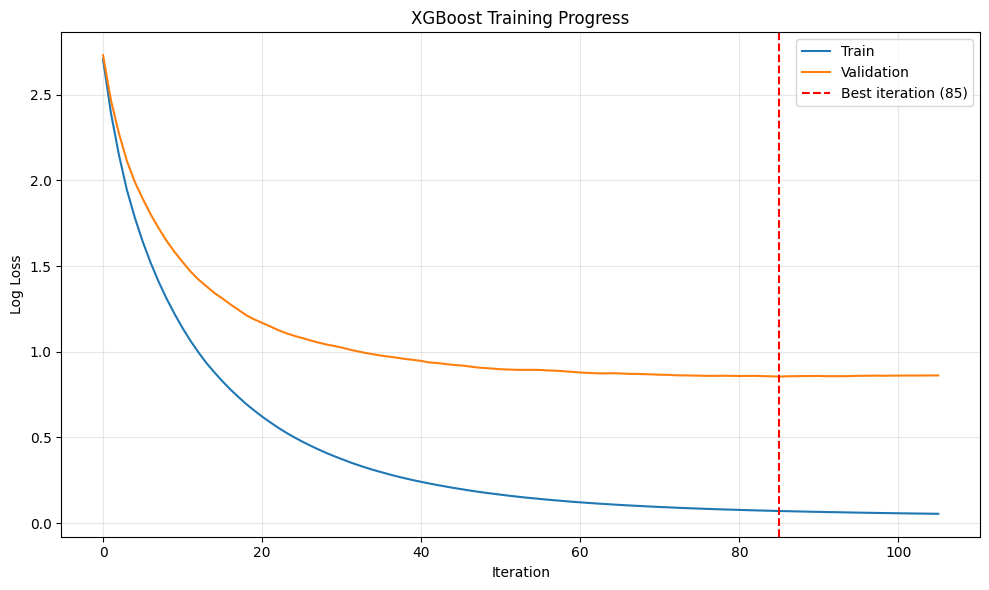


[?] Analizando importancia de features...

Top 20 features mas importantes (por gain):

                     feature_name  weight       gain
                             menu     1.0 130.915619
experience information technology     1.0 107.603912
                           flight     1.0  81.737961
                 personal trainer     1.0  75.915527
             construction project     5.0  65.058884
              experience business     3.0  51.903027
                         one year     1.0  51.475227
                         hardware     1.0  45.625542
                           farmer     1.0  43.773235
                   tight deadline     1.0  41.492493
                             navy     1.0  40.493908
           service representative     1.0  40.035194
                             idea     1.0  34.996696
                              lan     1.0  32.101025
                      eligibility     1.0  31.746349
                              aaa     1.0  29.703249
          

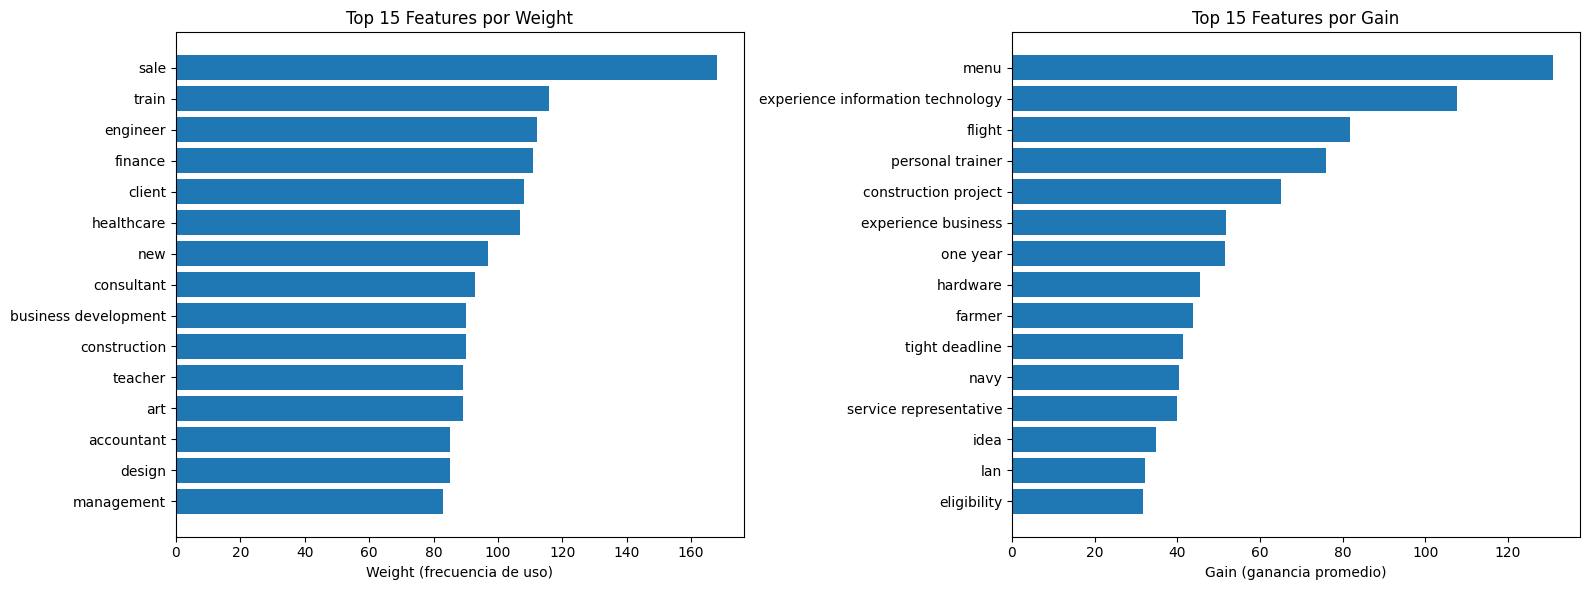


[?] EVALUACION EN VALIDATION SET

Metricas en Validation:

  Accuracy: 0.7328
  F1-Score (macro): 0.6872
  F1-Score (weighted): 0.7143
  ROC AUC (OvR): 0.9732

[?] EVALUACION EN TEST SET

[?] METRICAS EN TEST SET:

  Accuracy: 0.7922
  F1-Score (macro): 0.7606
  F1-Score (weighted): 0.7849
  ROC AUC (OvR): 0.9816

REPORTE DE CLASIFICACION DETALLADO

                        precision    recall  f1-score   support

            ACCOUNTANT     0.7692    0.8333    0.8000        12
              ADVOCATE     0.6875    0.9167    0.7857        12
           AGRICULTURE     1.0000    0.6667    0.8000         9
               APPAREL     1.0000    0.5000    0.6667        10
                  ARTS     0.5000    0.5000    0.5000        10
            AUTOMOBILE     0.5000    0.2000    0.2857         5
              AVIATION     0.8333    0.8333    0.8333        12
               BANKING     0.8000    0.7273    0.7619        11
                   BPO     1.0000    0.2500    0.4000         4
  BUSI

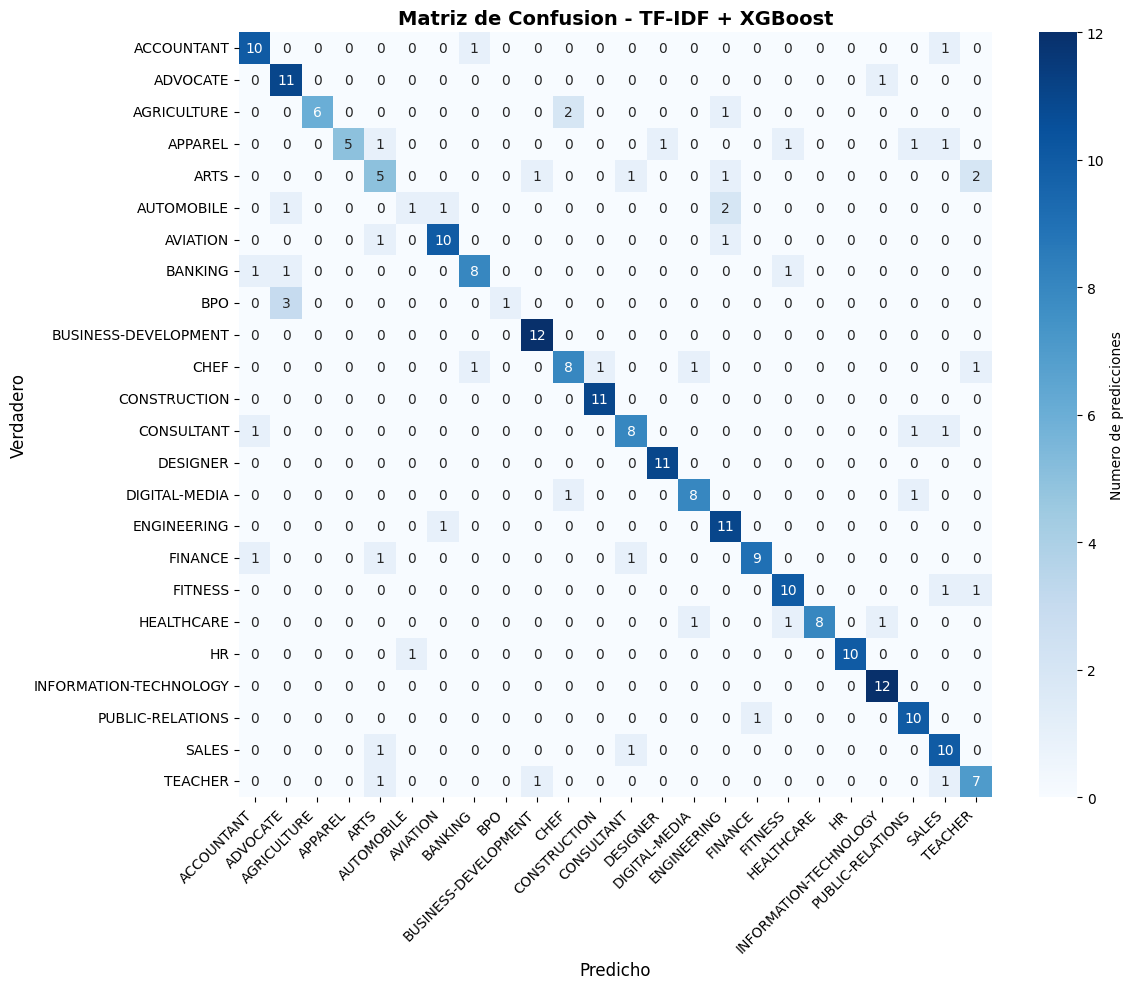


[?] ANALISIS DETALLADO POR CLASE

                 Clase  Muestras Test  Precision   Recall  F1-Score
              DESIGNER             11   0.916667 1.000000  0.956522
          CONSTRUCTION             11   0.916667 1.000000  0.956522
                    HR             11   1.000000 0.909091  0.952381
  BUSINESS-DEVELOPMENT             12   0.857143 1.000000  0.923077
INFORMATION-TECHNOLOGY             12   0.857143 1.000000  0.923077
            HEALTHCARE             11   1.000000 0.727273  0.842105
              AVIATION             12   0.833333 0.833333  0.833333
      PUBLIC-RELATIONS             11   0.769231 0.909091  0.833333
               FINANCE             12   0.900000 0.750000  0.818182
         DIGITAL-MEDIA             10   0.800000 0.800000  0.800000
            ACCOUNTANT             12   0.769231 0.833333  0.800000
               FITNESS             12   0.769231 0.833333  0.800000
           AGRICULTURE              9   1.000000 0.666667  0.800000
             

In [ ]:
# @title xgboost
import os
os.environ["WANDB_DISABLED"] = "true"

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports completados\n")

XGB_PARAMS = {
    'objective': 'multi:softprob',
    'num_class': None,
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'tree_method': 'hist',
    'device': 'cuda',
    'predictor': 'gpu_predictor',
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'mlogloss'
}


EARLY_STOPPING_ROUNDS = 20

print("[?] Verificando GPU para XGBoost...")
try:
    xgb.get_config()['use_rmm']
    print("✅ GPU disponible para XGBoost\n")
except:
    print("[?] GPU no disponible, usando CPU")
    XGB_PARAMS['tree_method'] = 'hist'
    del XGB_PARAMS['device']
    del XGB_PARAMS['predictor']
    print()


print("="*70)
print("📊 PREPARACION DE DATOS PARA TF-IDF + XGBOOST")
print("="*70 + "\n")

data_for_models, original_ids_for_models = get_data_for_models()

(X_train, X_val, X_test,
 y_train, y_val, y_test,
 label_encoder, num_classes,
 class_weights_numpy, class_weights_tensor,
 sample_weights_train) = prepare_data_for_training(
    data_for_models, "text_advanced", "Category", device=device, group_ids=original_ids_for_models
)

XGB_PARAMS['num_class'] = num_classes


print("="*70)
print("[?] VECTORIZACION TF-IDF")
print("="*70 + "\n")

print(f"Configuracion TF-IDF:")
print(f"  - Max features: 10000")
print(f"  - Min DF: 2")
print(f"  - Max DF: 0.95")
print(f"  - N-gram range: (1, 3)\n")

vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 3),
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True,
    analyzer='word',
    token_pattern=r'\b\w+\b'
)

print("[?] Ajustando TF-IDF en datos de entrenamiento...")
X_train_tfidf = vectorizer.fit_transform(X_train)

print("[?] Transformando datos de validacion y test...")
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\n✅ Vectorizacion completada")
print(f"   Vocabulario: {len(vectorizer.vocabulary_)} palabras")
print(f"   Shape train: {X_train_tfidf.shape}")
print(f"   Shape val: {X_val_tfidf.shape}")
print(f"   Shape test: {X_test_tfidf.shape}")
print(f"   Sparsity: {(1 - X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)) * 100:.2f}%\n")

print(f"\n📝 Top 20 features mas importantes:")
tfidf_sums = np.asarray(X_train_tfidf.sum(axis=0)).flatten()
top_indices = tfidf_sums.argsort()[-20:][::-1]
for idx in top_indices:
    print(f"   {feature_names[idx]:20s} \u2192 {tfidf_sums[idx]:.2f}")

print("\n" + "="*70 + "\n")


print("="*70)
print("🚀 ENTRENAMIENTO XGBOOST CON GPU")
print("="*70 + "\n")

print("Hiperparametros XGBoost:")
for key, value in XGB_PARAMS.items():
    print(f"  {key:20s} = {value}")
print()

print("[?] Creando DMatrix...")
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train, weight=sample_weights_train)
dval = xgb.DMatrix(X_val_tfidf, label=y_val)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

print("✅ DMatrix creado\n")

evallist = [(dtrain, 'train'), (dval, 'eval')]

print("🚀 Iniciando entrenamiento...\n")
print("-" * 70)

evals_result = {}
model = xgb.train(
    XGB_PARAMS,
    dtrain,
    num_boost_round=XGB_PARAMS['n_estimators'],
    evals=evallist,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    evals_result=evals_result,
    verbose_eval=10
)

print("\n" + "-" * 70)
print(f"✅ Entrenamiento completado")
print(f"   Best iteration: {model.best_iteration}")
print(f"   Best score: {model.best_score:.4f}\n")


print("[?] Generando graficas...\n")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

epochs = len(evals_result['train']['mlogloss'])
x_axis = range(epochs)

ax.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
ax.plot(x_axis, evals_result['eval']['mlogloss'], label='Validation')
ax.axvline(model.best_iteration, color='r', linestyle='--', label=f'Best iteration ({model.best_iteration})')
ax.legend()
ax.set_ylabel('Log Loss')
ax.set_xlabel('Iteration')
ax.set_title('XGBoost Training Progress')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\n[?] Analizando importancia de features...\n")

importance_dict = model.get_score(importance_type='weight')
importance_gain = model.get_score(importance_type='gain')

importance_df = pd.DataFrame({
    'feature': [f'f{i}' for i in range(len(feature_names))],
    'feature_name': feature_names,
    'weight': [importance_dict.get(f'f{i}', 0) for i in range(len(feature_names))],
    'gain': [importance_gain.get(f'f{i}', 0) for i in range(len(feature_names))]
})

importance_df = importance_df.sort_values('gain', ascending=False)

print("Top 20 features mas importantes (por gain):\n")
print(importance_df.head(20)[['feature_name', 'weight', 'gain']].to_string(index=False))
print()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_weight = importance_df.nlargest(15, 'weight')
axes[0].barh(top_weight['feature_name'], top_weight['weight'])
axes[0].set_xlabel('Weight (frecuencia de uso)')
axes[0].set_title('Top 15 Features por Weight')
axes[0].invert_yaxis()

top_gain = importance_df.nlargest(15, 'gain')
axes[1].barh(top_gain['feature_name'], top_gain['gain'])
axes[1].set_xlabel('Gain (ganancia promedio)')
axes[1].set_title('Top 15 Features por Gain')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


print("\n" + "="*70)
print("[?] EVALUACION EN VALIDATION SET")
print("="*70 + "\n")

y_val_proba = model.predict(dval)
y_val_pred = np.argmax(y_val_proba, axis=1)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

y_val_one_hot = np.eye(num_classes)[y_val]
val_roc_auc_ovr = roc_auc_score(y_val_one_hot, y_val_proba, average='macro', multi_class='ovr')

print("Metricas en Validation:\n")
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  F1-Score (macro): {val_f1_macro:.4f}")
print(f"  F1-Score (weighted): {val_f1_weighted:.4f}")
print(f"  ROC AUC (OvR): {val_roc_auc_ovr:.4f}\n")


print("="*70)
print("[?] EVALUACION EN TEST SET")
print("="*70 + "\n")

y_test_proba = model.predict(dtest)
y_test_pred = np.argmax(y_test_proba, axis=1)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

y_test_one_hot = np.eye(num_classes)[y_test]
test_roc_auc_ovr = roc_auc_score(y_test_one_hot, y_test_proba, average='macro', multi_class='ovr')

print(f"[?] METRICAS EN TEST SET:\n")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1-Score (macro): {test_f1_macro:.4f}")
print(f"  F1-Score (weighted): {test_f1_weighted:.4f}")
print(f"  ROC AUC (OvR): {test_roc_auc_ovr:.4f}\n")

print("="*70)
print("REPORTE DE CLASIFICACION DETALLADO")
print("="*70 + "\n")
print(classification_report(
    y_test,
    y_test_pred,
    labels=np.arange(num_classes),
    target_names=label_encoder.classes_,
    digits=4
))


print("\n[?] Generando matriz de confusion...\n")

cm = confusion_matrix(y_test, y_test_pred, labels=np.arange(num_classes))

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Numero de predicciones'}
)
plt.title('Matriz de Confusion - TF-IDF + XGBoost', fontsize=14, fontweight='bold')
plt.ylabel('Verdadero', fontsize=12)
plt.xlabel('Predicho', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("\n" + "="*70)
print("[?] ANALISIS DETALLADO POR CLASE")
print("="*70 + "\n")

from sklearn.metrics import precision_score, recall_score, f1_score

precision_per_class = precision_score(y_test, y_test_pred, average=None, labels=np.arange(num_classes), zero_division=0)
recall_per_class = recall_score(y_test, y_test_pred, average=None, labels=np.arange(num_classes), zero_division=0)
f1_per_class = f1_score(y_test, y_test_pred, average=None, labels=np.arange(num_classes), zero_division=0)

analysis_df = pd.DataFrame({
    'Clase': label_encoder.classes_,
    'Muestras Test': [np.sum(y_test == i) for i in range(num_classes)],
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

analysis_df = analysis_df.sort_values('F1-Score', ascending=False)

print(analysis_df.to_string(index=False))
print()

print("[?] Clases con F1-Score < 0.70:")
problematic = analysis_df[analysis_df['F1-Score'] < 0.70]
if len(problematic) > 0:
    print(problematic[['Clase', 'Muestras Test', 'F1-Score']].to_string(index=False))
else:
    print("   ✅ Todas las clases tienen F1-Score >= 0.70")


print("\n" + "="*70)
print("[?] GUARDANDO MODELO Y ARTEFACTOS")
print("="*70 + "\n")

model.save_model('xgboost_model.json')
print("✅ Modelo XGBoost guardado: xgboost_model.json")

import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("✅ Vectorizador TF-IDF guardado: tfidf_vectorizer.pkl")

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder guardado: label_encoder.pkl")

config = {
    'max_features': 10000,
    'min_df': 2,
    'max_df': 0.95,
    'ngram_range': (1, 3),
    'num_classes': num_classes,
    'class_names': label_encoder.classes_.tolist(),
    'xgb_params': XGB_PARAMS,
    'vocab_size': len(vectorizer.vocabulary_),
    'test_accuracy': test_accuracy,
    'test_f1_macro': test_f1_macro,
    'test_f1_weighted': test_f1_weighted,
    'test_roc_auc_ovr': test_roc_auc_ovr
}

import json
with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("✅ Configuracion guardada: model_config.json")

print("\n" + "="*70)
print("🎉 PROCESO COMPLETADO")
print("="*70)


print("\n📝 Ejemplo de funcion de prediccion:\n")

def predict_resume_category(text, model_path='xgboost_model.json',
                           vectorizer_path='tfidf_vectorizer.pkl',
                           label_encoder_path='label_encoder.pkl'):
    """
    Predice la categoria de un CV.

    Args:
        text: Texto del CV (debe estar limpio con text_advanced)
        model_path: Ruta al modelo XGBoost
        vectorizer_path: Ruta al vectorizador TF-IDF
        label_encoder_path: Ruta al label encoder

    Returns:
        Categoria predicha y probabilidades
    """
    import pickle
    import xgboost as xgb

    model = xgb.Booster()
    model.load_model(model_path)

    with open(vectorizer_path, 'rb') as f:
        vectorizer = pickle.load(f)

    with open(label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)

    text_tfidf = vectorizer.transform([text])
    dmatrix = xgb.DMatrix(text_tfidf)

    pred_proba = model.predict(dmatrix)
    pred_label = int(np.argmax(pred_proba))
    pred_category = label_encoder.inverse_transform([pred_label])[0]

    return pred_category, pred_proba

print("""
# Ejemplo de uso:
from tu_modulo import predict_resume_category

texto_cv = "tu texto de cv limpio con text_advanced..."
categoria, probabilidades = predict_resume_category(texto_cv)
print(f"Categoria predicha: {categoria}")
print(f"Probabilidades: {probabilidades}")
""")

print("✅ Todo listo para usar el modelo")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.9 MB/s eta 0:00:00
✅ Imports completados

[INFO] Dispositivo: cuda

📊 PREPARACION DE DATOS PARA CNN-1D


✔ Iniciando pipeline de preparacion de datos para modelos...
   [INFO] Google Drive ya montado.

✔ Intentando cargar dataframe aumentado desde Google Drive: /content/drive/MyDrive/data_augmented_processed.csv
✅ Dataframe aumentado cargado desde Google Drive: 2621 filas, 8 columnas.
   ✓ 'text_medium' columna llenada/regenerada para 1 filas.
   ✓ 'text_advanced' columna llenada/regenerada para 1 filas.
   ✀ Total de filas afectadas por la regeneracion de columnas: 2 (Detalles: 'text_medium' (1 nulls), 'text_advanced' (1 nulls))

   ✔ DataFrame actualizado y guardado en Google Drive: /content/drive/MyDrive/data_augmented_processed.csv
✅ Pipeline de preparacion de datos completado.

░░ PREPARANDO DATOS (SPLIT, ENCODING, PESOS DE CLASE)

Clases detectadas: 24
Mapping de clases: {i: label for i, label in enumerate(label_encoder.


📊 Resultados:
   Train - Loss: 3.1514 | Acc: 0.1454
   Val   - Loss: 2.1990 | Acc: 0.3931 | F1(macro): 0.3299 | F1(weighted): 0.3424 | ROC AUC (OvR): 0.8843
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.8843)

📍 Epoca 2/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 2.1986 | Acc: 0.3546
   Val   - Loss: 1.7592 | Acc: 0.5038 | F1(macro): 0.4582 | F1(weighted): 0.4742 | ROC AUC (OvR): 0.9186
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9186)

📍 Epoca 3/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 1.6909 | Acc: 0.5038
   Val   - Loss: 1.6207 | Acc: 0.5076 | F1(macro): 0.4575 | F1(weighted): 0.4739 | ROC AUC (OvR): 0.9317
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9317)

📍 Epoca 4/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 1.3706 | Acc: 0.5841
   Val   - Loss: 1.4970 | Acc: 0.5878 | F1(macro): 0.5180 | F1(weighted): 0.5372 | ROC AUC (OvR): 0.9429
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9429)

📍 Epoca 5/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 1.0558 | Acc: 0.6906
   Val   - Loss: 1.2596 | Acc: 0.6412 | F1(macro): 0.5874 | F1(weighted): 0.6111 | ROC AUC (OvR): 0.9519
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9519)

📍 Epoca 6/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 0.8261 | Acc: 0.7538
   Val   - Loss: 1.2282 | Acc: 0.6565 | F1(macro): 0.5972 | F1(weighted): 0.6217 | ROC AUC (OvR): 0.9564
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9564)

📍 Epoca 7/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 0.6276 | Acc: 0.8194
   Val   - Loss: 1.1097 | Acc: 0.6908 | F1(macro): 0.6272 | F1(weighted): 0.6535 | ROC AUC (OvR): 0.9628
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9628)

📍 Epoca 8/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 0.5344 | Acc: 0.8398
   Val   - Loss: 1.0616 | Acc: 0.7061 | F1(macro): 0.6517 | F1(weighted): 0.6796 | ROC AUC (OvR): 0.9696
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9696)

📍 Epoca 9/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 0.4028 | Acc: 0.8878
   Val   - Loss: 1.0320 | Acc: 0.7366 | F1(macro): 0.6818 | F1(weighted): 0.7088 | ROC AUC (OvR): 0.9699
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9699)

📍 Epoca 10/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 0.3011 | Acc: 0.9140
   Val   - Loss: 1.0176 | Acc: 0.7061 | F1(macro): 0.6494 | F1(weighted): 0.6779 | ROC AUC (OvR): 0.9721
   ✅ Mejor modelo guardado (ROC AUC OvR: 0.9721)

📍 Epoca 11/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 0.2286 | Acc: 0.9463
   Val   - Loss: 1.0252 | Acc: 0.7176 | F1(macro): 0.6667 | F1(weighted): 0.6953 | ROC AUC (OvR): 0.9658
   ⏳ Patience: 1/3

📍 Epoca 12/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 0.1792 | Acc: 0.9582
   Val   - Loss: 0.9808 | Acc: 0.7519 | F1(macro): 0.6990 | F1(weighted): 0.7281 | ROC AUC (OvR): 0.9681
   ⏳ Patience: 2/3

📍 Epoca 13/20
----------------------------------------------------------------------



📊 Resultados:
   Train - Loss: 0.1438 | Acc: 0.9686
   Val   - Loss: 1.0040 | Acc: 0.7405 | F1(macro): 0.6870 | F1(weighted): 0.7155 | ROC AUC (OvR): 0.9677
   ⏳ Patience: 3/3

❌ Early stopping activado en epoca 13

✅ ENTRENAMIENTO COMPLETADO

📈 Generando graficas...



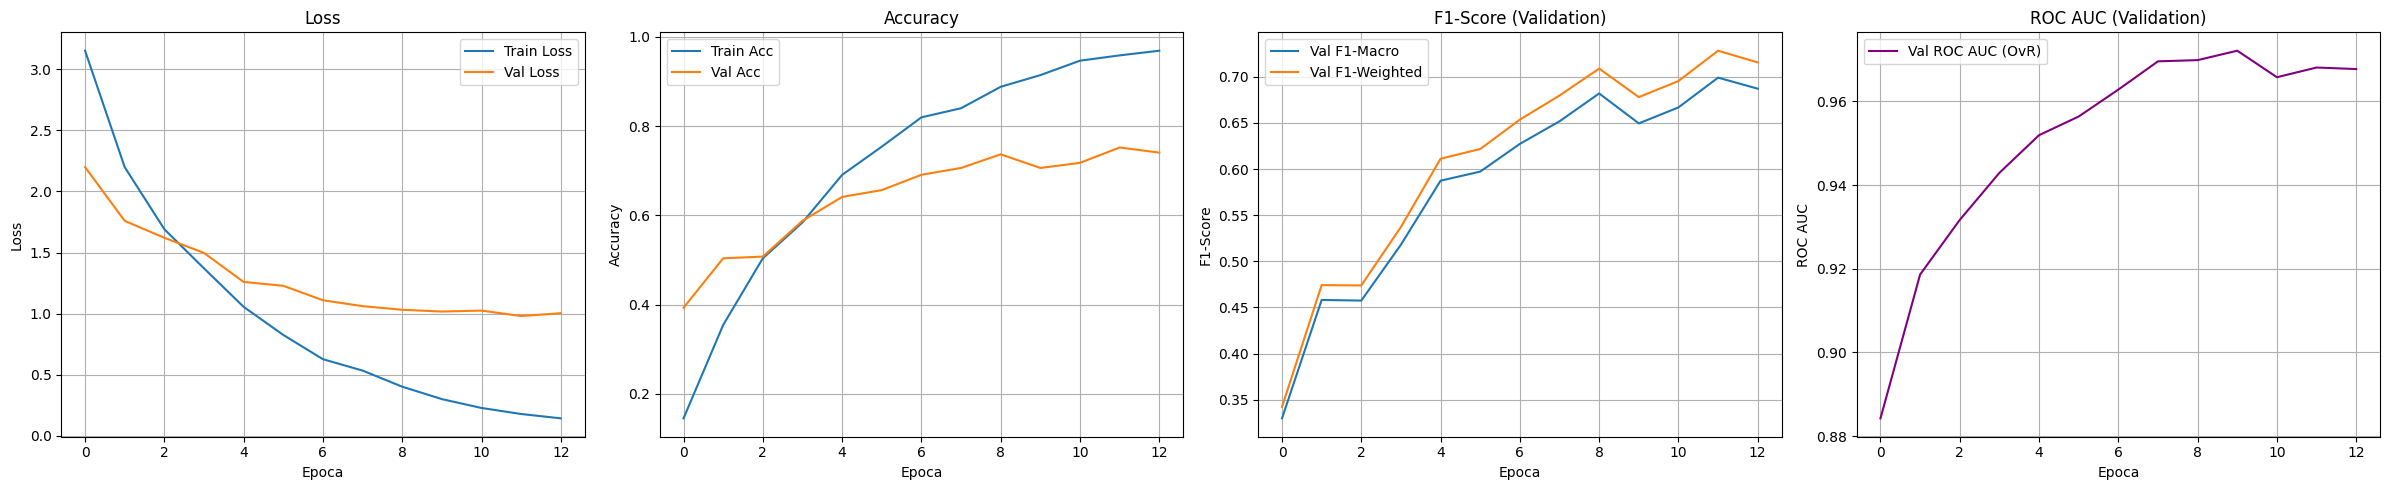


🧪 EVALUACION EN TEST SET

📊 METRICAS EN TEST SET:
   Loss: 1.0542
   Accuracy: 0.7333
   F1-Score (macro): 0.6716
   F1-Score (weighted): 0.7112
   ROC AUC (OvR): 0.9633

REPORTE DE CLASIFICACION DETALLADO

                        precision    recall  f1-score   support

            ACCOUNTANT     0.9000    0.7500    0.8182        12
              ADVOCATE     0.6923    0.7500    0.7200        12
           AGRICULTURE     1.0000    0.6667    0.8000         9
               APPAREL     0.5000    0.1000    0.1667        10
                  ARTS     0.6364    0.7000    0.6667        10
            AUTOMOBILE     0.0000    0.0000    0.0000         5
              AVIATION     0.7273    0.6667    0.6957        12
               BANKING     0.7000    0.6364    0.6667        11
                   BPO     0.0000    0.0000    0.0000         4
  BUSINESS-DEVELOPMENT     0.7059    1.0000    0.8276        12
                  CHEF     1.0000    0.7500    0.8571        12
          CONSTRUCTION 

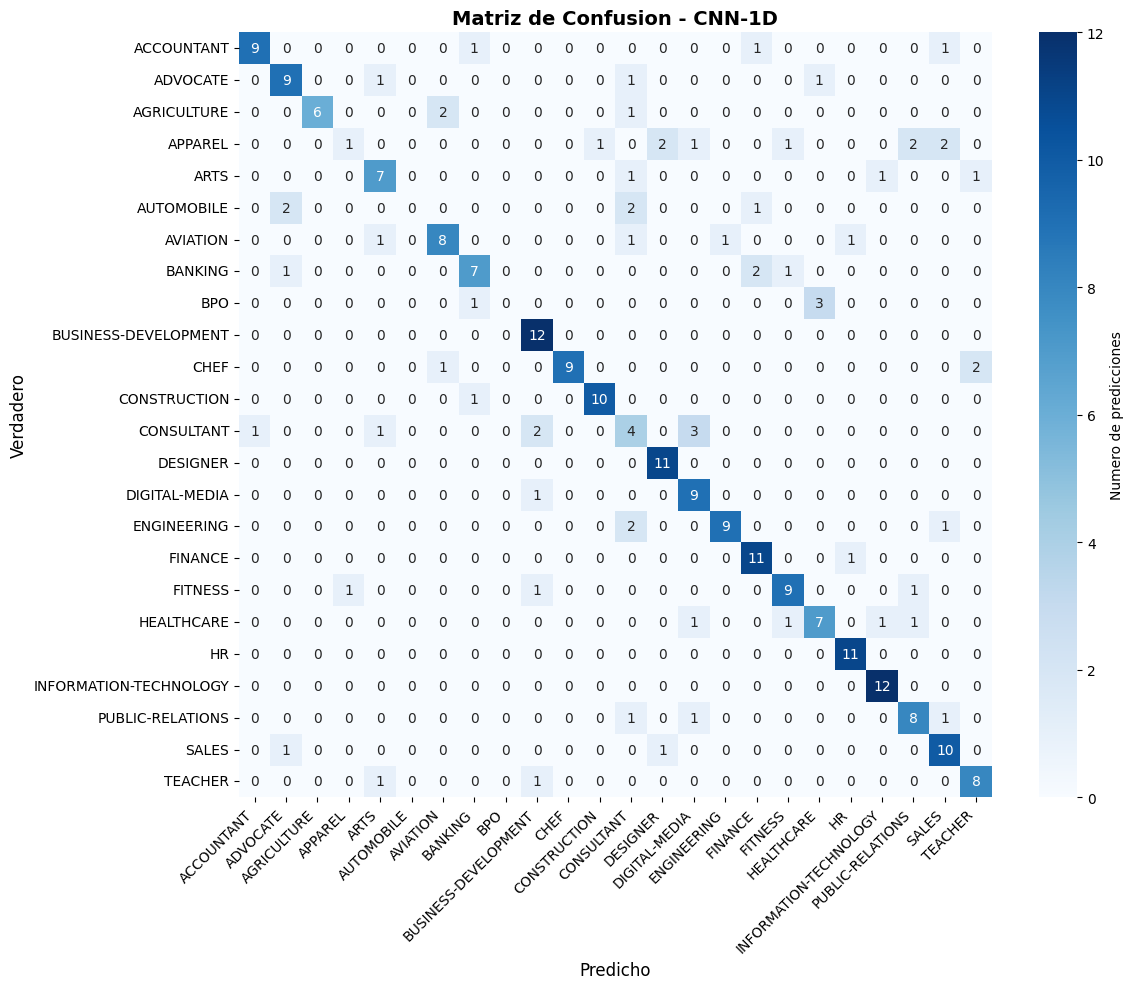


💾 Guardando modelo y artefactos...

✅ Modelo guardado en: cnn_model_complete.pth

🎉 PROCESO COMPLETADO


In [ ]:
# @title CNN
!pip install gensim torch scikit-learn matplotlib seaborn -q

import os
os.environ["WANDB_DISABLED"] = "true"

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
import gensim.downloader as api

print("✅ Imports completados\n")

MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 300
VOCAB_SIZE = 50000

NUM_FILTERS = 128
KERNEL_SIZES = [2, 3, 4, 5]
DROPOUT_RATE = 0.5

BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Dispositivo: {device}\n")

print("="*70)
print("📊 PREPARACION DE DATOS PARA CNN-1D")
print("="*70 + "\n")

data_for_models, original_ids_for_models = get_data_for_models()

(X_train, X_val, X_test,
 y_train, y_val, y_test,
 label_encoder, num_classes,
 class_weights_numpy, class_weights_tensor,
 sample_weights_train) = prepare_data_for_training(
    data_for_models, "text_advanced", "Category", device=device, group_ids=original_ids_for_models
)


print("📝 Tokenizando y construyendo vocabulario...\n")

def tokenize(text):
    return str(text).split()

train_tokens = [tokenize(text) for text in X_train]

from collections import Counter

word_counts = Counter()
for tokens in train_tokens:
    word_counts.update(tokens)

vocab = ['<PAD>', '<UNK>'] + [word for word, _ in word_counts.most_common(VOCAB_SIZE - 2)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

print(f"✅ Vocabulario construido: {len(vocab)} palabras")
print(f"   Palabras mas comunes: {list(word_counts.most_common(10))}\n")


def text_to_sequence(text, word_to_idx, max_length):
    """Convierte texto a secuencia de indices."""
    tokens = tokenize(str(text))
    sequence = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]

    if len(sequence) < max_length:
        sequence = sequence + [word_to_idx['<PAD>']] * (max_length - len(sequence))
    else:
        sequence = sequence[:max_length]

    return sequence

print("🔢 Convirtiendo textos a secuencias...\n")

X_train_seq = np.array([text_to_sequence(text, word_to_idx, MAX_SEQUENCE_LENGTH) for text in X_train])
X_val_seq = np.array([text_to_sequence(text, word_to_idx, MAX_SEQUENCE_LENGTH) for text in X_val])
X_test_seq = np.array([text_to_sequence(text, word_to_idx, MAX_SEQUENCE_LENGTH) for text in X_test])

print(f"✅ Secuencias creadas")
print(f"   Shape train: {X_train_seq.shape}")
print(f"   Shape val: {X_val_seq.shape}")
print(f"   Shape test: {X_test_seq.shape}\n")


print("="*70)
print("🎯 CARGANDO EMBEDDINGS PREENTRENADOS")
print("="*70 + "\n")

print("Selecciona embeddings preentrenados:")
print("  1. Word2Vec GoogleNews (300d) - ~1.5GB")
print("  2. GloVe Twitter (200d) - mas rapido")
print("  3. Entrenar Word2Vec localmente (mas rapido, pero menos robusto)")
print()

EMBEDDING_CHOICE = 3

if EMBEDDING_CHOICE == 1:
    print("📥 Descargando Word2Vec GoogleNews (esto puede tardar varios minutos)...")
    pretrained_embeddings = api.load("word2vec-google-news-300")
    EMBEDDING_DIM = 300

elif EMBEDDING_CHOICE == 2:
    print("📥 Descargando GloVe Twitter...")
    pretrained_embeddings = api.load("glove-twitter-200")
    EMBEDDING_DIM = 200

else:
    print("🔄 Entrenando Word2Vec localmente en tus datos...")
    pretrained_embeddings = Word2Vec(
        sentences=train_tokens,
        vector_size=EMBEDDING_DIM,
        window=5,
        min_count=2,
        workers=4,
        epochs=10
    )

print("✅ Embeddings cargados\n")


print("🏗️  Creando matriz de embeddings para vocabulario...\n")

embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIM))
found_words = 0

for word, idx in word_to_idx.items():
    if word in ['<PAD>', '<UNK>']:
        continue

    try:
        if EMBEDDING_CHOICE == 3:
            embedding_vector = pretrained_embeddings.wv[word]
        else:
            embedding_vector = pretrained_embeddings[word]

        embedding_matrix[idx] = embedding_vector
        found_words += 1
    except KeyError:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

coverage = found_words / len(vocab) * 100
print(f"✅ Matriz de embeddings creada")
print(f"   Cobertura: {found_words}/{len(vocab)} palabras ({coverage:.1f}%)")
print(f"   Shape: {embedding_matrix.shape}\n")


class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TextDataset(X_train_seq, y_train)
val_dataset = TextDataset(X_val_seq, y_val)
test_dataset = TextDataset(X_test_seq, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ DataLoaders creados")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}\n")


print("="*70)
print("🏗️ CONSTRUYENDO MODELO CNN-1D")
print("="*70 + "\n")

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes,
                 num_filters, kernel_sizes, dropout_rate,
                 pretrained_embeddings=None, freeze_embeddings=False):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))

        if freeze_embeddings:
            self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k
            )
            for k in kernel_sizes
        ])

        self.dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)

        embedded = embedded.permute(0, 2, 1)

        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(embedded))

            pooled = F.max_pool1d(conv_out, conv_out.size(2))

            conv_outputs.append(pooled.squeeze(2))

        concatenated = torch.cat(conv_outputs, dim=1);

        dropped = self.dropout(concatenated)

        logits = self.fc(dropped)

        return logits


model = TextCNN(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    num_classes=num_classes,
    num_filters=NUM_FILTERS,
    kernel_sizes=KERNEL_SIZES,
    dropout_rate=DROPOUT_RATE,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False
).to(device)

print("✅ Modelo creado\n")
print(model)
print(f"\n📊 Parametros totales: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Parametros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")


print("="*70)
print("🎯 CONFIGURANDO ENTRENAMIENTO")
print("="*70 + "\n")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print(f"✅ Configuracion lista")
print(f"   Loss: CrossEntropyLoss con class weights")
print(f"   Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   Scheduler: ReduceLROnPlateau\n")


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for sequences, labels in progress_bar:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)

        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        total_loss += loss.item() * sequences.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device, num_classes):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probas = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * sequences.size(0)

            probas = F.softmax(outputs, dim=1)

            _, predicted = torch.max(probas, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probas.extend(probas.cpu().numpy())

    avg_loss = total_loss / total
    accuracy = correct / total
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    all_labels_one_hot = np.eye(num_classes)[all_labels]
    roc_auc_ovr = roc_auc_score(all_labels_one_hot, np.array(all_probas), average='macro', multi_class='ovr')

    return avg_loss, accuracy, f1_macro, f1_weighted, roc_auc_ovr, all_preds, all_labels


print("="*70)
print("🚀 INICIANDO ENTRENAMIENTO")
print("="*70 + "\n")

best_val_roc_auc_ovr = 0
patience_counter = 0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1_macro': [], 'val_f1_weighted': [], 'val_roc_auc_ovr': []
}

for epoch in range(EPOCHS):
    print(f"\n📍 Epoca {epoch+1}/{EPOCHS}")
    print("-" * 70)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc, val_f1_macro, val_f1_weighted, val_roc_auc_ovr, _, _ = evaluate(
        model, val_loader, criterion, device, num_classes
    )

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1_macro'].append(val_f1_macro)
    history['val_f1_weighted'].append(val_f1_weighted)
    history['val_roc_auc_ovr'].append(val_roc_auc_ovr)

    print(f"\n📊 Resultados:")
    print(f"   Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"   Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1(macro): {val_f1_macro:.4f} | F1(weighted): {val_f1_weighted:.4f} | ROC AUC (OvR): {val_roc_auc_ovr:.4f}")

    if val_roc_auc_ovr > best_val_roc_auc_ovr:
        best_val_roc_auc_ovr = val_roc_auc_ovr
        patience_counter = 0
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print(f"   ✅ Mejor modelo guardado (ROC AUC OvR: {best_val_roc_auc_ovr:.4f})")
    else:
        patience_counter += 1
        print(f"   ⏳ Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n❌ Early stopping activado en epoca {epoch+1}")
            break

print("\n" + "="*70)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*70 + "\n")


print("📈 Generando graficas...\n")

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(history['val_f1_macro'], label='Val F1-Macro')
axes[2].plot(history['val_f1_weighted'], label='Val F1-Weighted')
axes[2].set_title('F1-Score (Validation)')
axes[2].set_xlabel('Epoca')
axes[2].set_ylabel('F1-Score')
axes[2].legend()
axes[2].grid(True)

axes[3].plot(history['val_roc_auc_ovr'], label='Val ROC AUC (OvR)', color='purple')
axes[3].set_title('ROC AUC (Validation)')
axes[3].set_xlabel('Epoca')
axes[3].set_ylabel('ROC AUC')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


print("\n" + "="*70)
print("🧪 EVALUACION EN TEST SET")
print("="*70 + "\n")

model.load_state_dict(torch.load('best_cnn_model.pth'))

test_loss, test_acc, test_f1_macro, test_f1_weighted, test_roc_auc_ovr, y_pred, y_true = evaluate(
    model, test_loader, criterion, device, num_classes
)

print("📊 METRICAS EN TEST SET:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.4f}")
print(f"   F1-Score (macro): {test_f1_macro:.4f}")
print(f"   F1-Score (weighted): {test_f1_weighted:.4f}")
print(f"   ROC AUC (OvR): {test_roc_auc_ovr:.4f}\n")

print("="*70)
print("REPORTE DE CLASIFICACION DETALLADO")
print("="*70 + "\n")
print(classification_report(
    y_true,
    y_pred,
    labels=label_encoder.transform(label_encoder.classes_),
    target_names=label_encoder.classes_,
    digits=4
))


print("\n📊 Generando matriz de confusion...\n")

cm = confusion_matrix(y_true, y_pred, labels=label_encoder.transform(label_encoder.classes_))

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Numero de predicciones'}
)
plt.title('Matriz de Confusion - CNN-1D', fontsize=14, fontweight='bold')
plt.ylabel('Verdadero', fontsize=12)
plt.xlabel('Predicho', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("\n💾 Guardando modelo y artefactos...\n")

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'word_to_idx': word_to_idx,
    'label_encoder': label_encoder,
    'config': {
        'max_seq_length': MAX_SEQUENCE_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'num_filters': NUM_FILTERS,
        'kernel_sizes': KERNEL_SIZES,
        'dropout_rate': DROPOUT_RATE,
        'num_classes': num_classes,
        'test_accuracy': test_acc,
        'test_f1_macro': test_f1_macro,
        'test_f1_weighted': test_f1_weighted,
        'test_roc_auc_ovr': test_roc_auc_ovr
    }
}, 'cnn_model_complete.pth')

print("✅ Modelo guardado en: cnn_model_complete.pth")
print("\n" + "="*70)
print("🎉 PROCESO COMPLETADO")
print("="*70)

✅ Imports completados

▥̲░▥̲  Dispositivo: cuda

📊 Espacio de hiperparámetros:
  lstm_units          : [32, 64]
  num_lstm_layers     : [1, 2]
  dropout_rate        : [0.6, 0.8]
  learning_rate       : [0.001, 0.002]
  batch_size          : [32, 64]
  sequence_length     : [700]
  epochs              : [15, 30]
  embedding_dim       : [50, 100]

Total combinaciones posibles: 128
Combinaciones a probar: 20

📊 PREPARACIÓN DE DATOS PARA WORD2VEC + BiLSTM


✔ Iniciando pipeline de preparacion de datos para modelos...
   [INFO] Google Drive ya montado.

✔ Intentando cargar dataframe aumentado desde Google Drive: /content/drive/MyDrive/data_augmented_processed.csv
✅ Dataframe aumentado cargado desde Google Drive: 2621 filas, 8 columnas.
   ✓ 'text_medium' columna llenada/regenerada para 1 filas.
   ✓ 'text_advanced' columna llenada/regenerada para 1 filas.
   ✀ Total de filas afectadas por la regeneracion de columnas: 2 (Detalles: 'text_medium' (1 nulls), 'text_advanced' (1 nulls))

   ✔ Dat

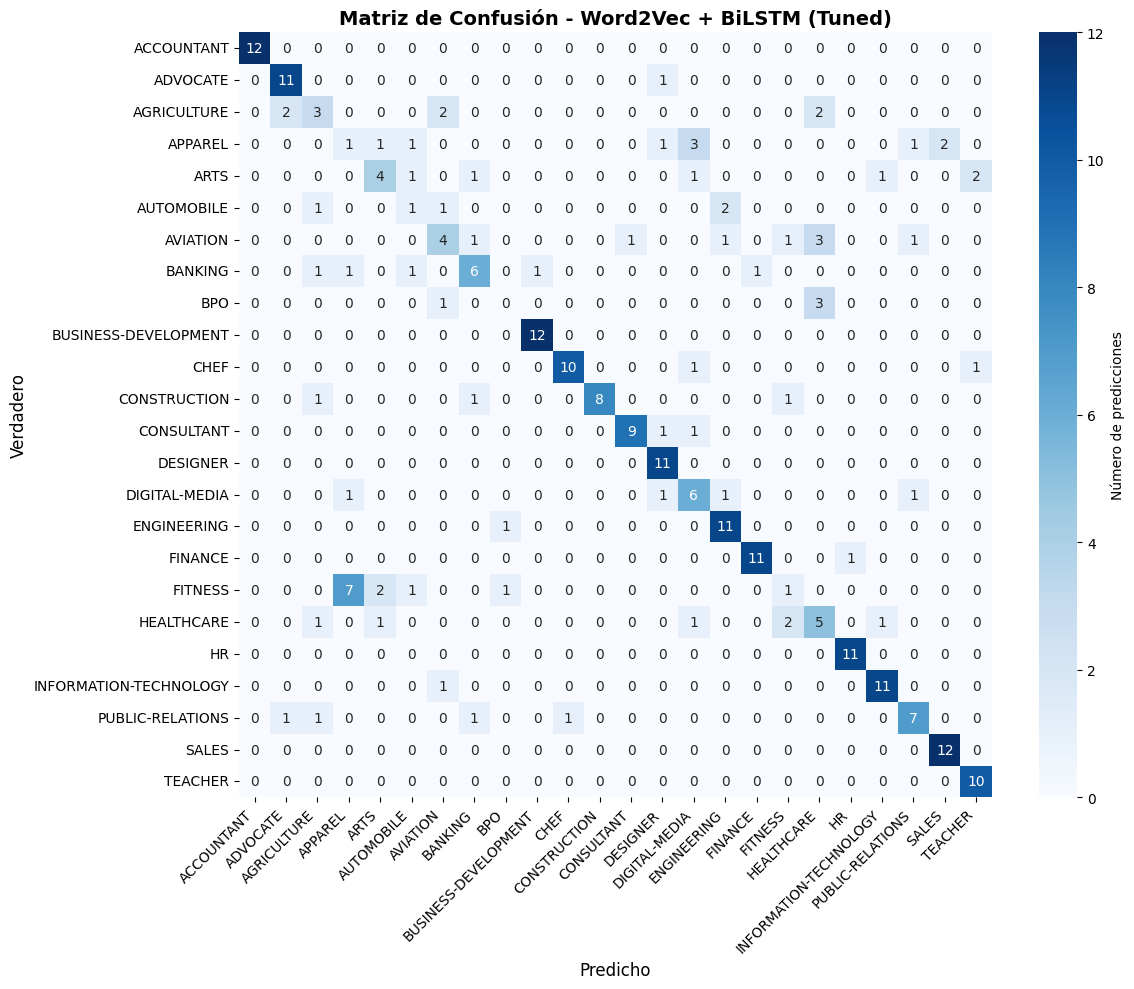


↗▒ Generando gráficas de entrenamiento...



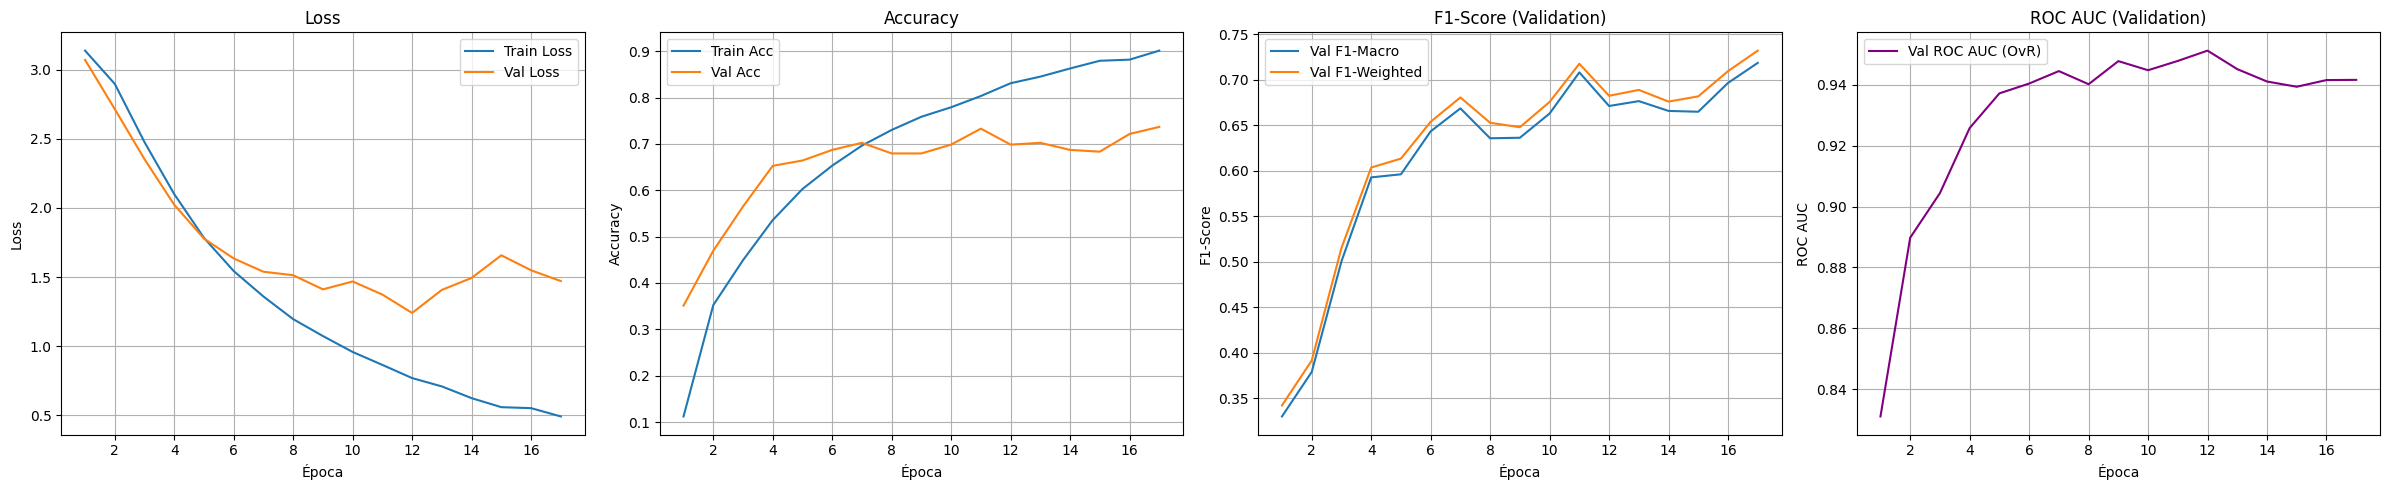


|▒ Guardando modelo y artefactos...

✅ Modelo guardado en: bilstm_model_best.pth
✅ Word2Vec guardado: word22vec_model.bin
✅ Resultados guardados: bilstm_search_results.json

✨▒ PROCESO COMPLETADO - WORD2VEC + BiLSTM CON TUNING


In [ ]:
#@title bilstm
!pip install gensim torch scikit-learn matplotlib seaborn -q

import os
os.environ["WANDB_DISABLED"] = "true"

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec

print("✅ Imports completados\n")


VOCAB_SIZE = 50000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"▥̲░▥̲  Dispositivo: {device}\n")


param_grid = {
    'lstm_units': [32, 64],
    'num_lstm_layers': [1, 2],
    'dropout_rate': [ 0.6,0.8],
    'learning_rate': [0.001, 0.002],
    'batch_size': [32, 64],
    'sequence_length': [700],
    'epochs': [15, 30],
    'embedding_dim': [50, 100]
}


N_COMBINATIONS = 20
EARLY_STOPPING_PATIENCE = 5

print("📊 Espacio de hiperparámetros:")
for param, values in param_grid.items():
    print(f"  {param:20s}: {values}")
print(f"\nTotal combinaciones posibles: {np.prod([len(v) for v in param_grid.values()]):,}")
print(f"Combinaciones a probar: {N_COMBINATIONS}\n")


print("="*70)
print("📊 PREPARACIÓN DE DATOS PARA WORD2VEC + BiLSTM")
print("="*70 + "\n")

data_for_models, original_ids_for_models = get_data_for_models()

(X_train, X_val, X_test,
 y_train, y_val, y_test,
 label_encoder, num_classes,
 class_weights_numpy, class_weights_tensor,
 sample_weights_train) = prepare_data_for_training(
    data_for_models, "text_advanced", "Category", device=device, group_ids=original_ids_for_models
)

print(f"Shapes after preparation: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")


print("─░ Tokenizando y construyendo vocabulario...\n")

def tokenize(text):
    return str(text).split()

train_tokens = [tokenize(text) for text in X_train]

from collections import Counter

word_counts = Counter()
for tokens in train_tokens:
    word_counts.update(tokens)

vocab = ['<PAD>', '<UNK>'] + [word for word, _ in word_counts.most_common(VOCAB_SIZE - 2)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

print(f"✅ Vocabulario construido: {len(vocab)} palabras")
print(f"   Palabras mas comunes: {list(word_counts.most_common(10))}\n")


print("="*70)
print("|▒ ENTRENAMIENTO WORD2VEC LOCAL")
print("="*70 + "\n")

print("ℐ Entrenando modelo Word2Vec...")

MAX_EMBEDDING_DIM = max(param_grid['embedding_dim'])

word2vec_model = Word2Vec(
    sentences=train_tokens,
    vector_size=MAX_EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=1
)

print(f"✅ Word2Vec entrenado")
print(f"   Vocabulario Word2Vec: {len(word2vec_model.wv)} palabras")
print(f"   Dimensión: {MAX_EMBEDDING_DIM}\n")


def create_embedding_matrix(word_to_idx, word2vec_model, embedding_dim):
    """Crea matriz de embeddings desde Word2Vec."""
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    found_words = 0

    for word, idx in word_to_idx.items():
        if word in ['<PAD>', '<UNK>']:
            continue
        try:
            w2v_vector = word2vec_model.wv[word]
            if len(w2v_vector) > embedding_dim:
                embedding_matrix[idx] = w2v_vector[:embedding_dim]
            else:
                embedding_matrix[idx][:len(w2v_vector)] = w2v_vector
            found_words += 1
        except KeyError:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    coverage = found_words / len(word_to_idx) * 100
    return embedding_matrix, coverage


def text_to_sequence(text, word_to_idx, max_length):
    """Convierte texto a secuencia de indices."""
    tokens = tokenize(text)
    sequence = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]

    if len(sequence) < max_length:
        sequence = sequence + [word_to_idx['<PAD>']] * (max_length - len(sequence))
    else:
        sequence = sequence[:max_length]

    return sequence


def create_sequences(texts, word_to_idx, max_length):
    """Crea secuencias para un conjunto de textos."""
    return np.array([text_to_sequence(text, word_to_idx, max_length) for text in texts])


class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_units, num_lstm_layers,
                 num_classes, dropout_rate, pretrained_embeddings=None):
        super(BiLSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))

        self.lstm = nn.LSTM(
            embedding_dim,
            lstm_units,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_lstm_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(lstm_units * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        hidden_concat = torch.cat((hidden[-2], hidden[-1]), dim=1);

        dropped = self.dropout(hidden_concat)

        logits = self.fc(dropped)

        return logits


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in dataloader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences);
        loss = criterion(outputs, labels);
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device, num_classes):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probas = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences);
            loss = criterion(outputs, labels);

            total_loss += loss.item()

            probas = F.softmax(outputs, dim=1)

            _, predicted = torch.max(probas, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probas.extend(probas.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    all_labels_one_hot = np.eye(num_classes)[all_labels]
    roc_auc_ovr = roc_auc_score(all_labels_one_hot, np.array(all_probas), average='macro', multi_class='ovr')

    return avg_loss, accuracy, f1_macro, f1_weighted, roc_auc_ovr, all_preds, all_labels


def train_model_with_params(params, X_train, y_train, X_val, y_val,
                            word_to_idx, word2vec_model, num_classes,
                            class_weights_tensor, device):
    """Entrena un modelo con parámetros específicos."""

    embedding_matrix, coverage = create_embedding_matrix(
        word_to_idx, word2vec_model, params['embedding_dim']
    )

    X_train_seq = create_sequences(X_train, word_to_idx, params['sequence_length'])
    X_val_seq = create_sequences(X_val, word_to_idx, params['sequence_length'])

    train_dataset = TextDataset(X_train_seq, y_train)
    val_dataset = TextDataset(X_val_seq, y_val)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    model = BiLSTMClassifier(
        vocab_size=len(word_to_idx),
        embedding_dim=params['embedding_dim'],
        lstm_units=params['lstm_units'],
        num_lstm_layers=params['num_lstm_layers'],
        num_classes=num_classes,
        dropout_rate=params['dropout_rate'],
        pretrained_embeddings=embedding_matrix
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    best_val_roc_auc_ovr = 0
    patience_counter = 0
    history = []

    for epoch in range(params['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1_macro, val_f1_weighted, val_roc_auc_ovr, _, _ = evaluate(
            model, val_loader, criterion, device, num_classes
        )

        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1_macro': val_f1_macro,
            'val_f1_weighted': val_f1_weighted,
            'val_roc_auc_ovr': val_roc_auc_ovr
        })

        if val_roc_auc_ovr > best_val_roc_auc_ovr:
            best_val_roc_auc_ovr = val_roc_auc_ovr
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                break

    model.load_state_dict(best_model_state)

    return model, best_val_roc_auc_ovr, history


print("="*70)
print("✤ RANDOM SEARCH - HYPERPARAMETER TUNING")
print("="*70 + "\n")

np.random.seed(42)
all_results = []

for iteration in range(N_COMBINATIONS):
    print(f"\n{'='*70}")
    print(f"ℐ Iteración {iteration + 1}/{N_COMBINATIONS}")
    print(f"{'='*70}")

    params = {
        'lstm_units': int(np.random.choice(param_grid['lstm_units'])),
        'num_lstm_layers': int(np.random.choice(param_grid['num_lstm_layers'])),
        'dropout_rate': float(np.random.choice(param_grid['dropout_rate'])),
        'learning_rate': float(np.random.choice(param_grid['learning_rate'])),
        'batch_size': int(np.random.choice(param_grid['batch_size'])),
        'sequence_length': int(np.random.choice(param_grid['sequence_length'])),
        'epochs': int(np.random.choice(param_grid['epochs'])),
        'embedding_dim': int(np.random.choice(param_grid['embedding_dim']))
    }

    print("\nParámetros:")
    for key, value in params.items():
        print(f"  {key:20s} = {value}")
    print()

    try:
        model, best_roc_auc_ovr, history = train_model_with_params(
            params, X_train, y_train, X_val, y_val,
            word_to_idx, word2vec_model, num_classes,
            class_weights_tensor, device
        )

        print(f"\n✅ Mejor ROC AUC (val): {best_roc_auc_ovr:.4f}")
        print(f"   Épocas entrenadas: {len(history)}")

        all_results.append({
            'iteration': iteration + 1,
            'params': params.copy(),
            'best_val_roc_auc_ovr': best_roc_auc_ovr,
            'epochs_trained': len(history),
            'history': history,
            'model_state': model.state_dict().copy()
        })

    except Exception as e:
        print(f"\n❌ Error en iteración {iteration + 1}: {e}")
        continue


print("\n" + "="*70)
print("📊 RESUMEN DE BÚSEDA")
print("="*70 + "\n")

all_results.sort(key=lambda x: x['best_val_roc_auc_ovr'], reverse=True)

print(f"✅▒ Top 5 configuraciones:\n")
for i, result in enumerate(all_results[:5]):
    print(f"{i+1}. ROC AUC: {result['best_val_roc_auc_ovr']:.4f}")
    for key, value in result['params'].items():
        print(f"   {key:20s} = {value}")
    print()

best_result = all_results[0]
best_params = best_result['params']
best_roc_auc_ovr = best_result['best_val_roc_auc_ovr']

print(f"✅ MEJORES HIPERPARÁMETROS:")
for key, value in best_params.items():
    print(f"  {key:20s} = {value}")
print(f"\n⌶̲⌶̲⌶̲⌶̲⌶̲⌶̲⌶̲ Mejor ROC AUC (validation): {best_roc_auc_ovr:.4f}\n")


print("="*70)
print("✂▒ EVALUACIÓN FINAL EN TEST SET")
print("="*70 + "\n")

print("ℐ Recreando mejor modelo y evaluando en test...\n")

embedding_matrix, coverage = create_embedding_matrix(
    word_to_idx, word2vec_model, best_params['embedding_dim']
)
print(f"✅ Embedding matrix: cobertura {coverage:.1f}%\n")

X_test_seq = create_sequences(X_test, word_to_idx, best_params['sequence_length'])

best_model = BiLSTMClassifier(
    vocab_size=len(word_to_idx),
    embedding_dim=best_params['embedding_dim'],
    lstm_units=best_params['lstm_units'],
    num_lstm_layers=best_params['num_lstm_layers'],
    num_classes=num_classes,
    dropout_rate=best_params['dropout_rate'],
    pretrained_embeddings=embedding_matrix
).to(device)

best_model.load_state_dict(best_result['model_state'])

test_dataset = TextDataset(X_test_seq, y_test)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
test_loss, test_acc, test_f1_macro, test_f1_weighted, test_roc_auc_ovr, y_pred, y_true = evaluate(
    best_model, test_loader, criterion, device, num_classes
)

print("📊 MÉTRICAS EN TEST SET:\n")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.4f}")
print(f"   F1-Score (macro): {test_f1_macro:.4f}")
print(f"   F1-Score (weighted): {test_f1_weighted:.4f}")
print(f"   ROC AUC (OvR): {test_roc_auc_ovr:.4f}\n")

print("="*70)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*70 + "\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))


print("\n📊 Generando matriz de confusión...\n")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Número de predicciones'}
)
plt.title('Matriz de Confusión - Word2Vec + BiLSTM (Tuned)', fontsize=14, fontweight='bold')
plt.ylabel('Verdadero', fontsize=12)
plt.xlabel('Predicho', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("\n↗▒ Generando gráficas de entrenamiento...\n")

history_df = pd.DataFrame(best_result['history'])

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

axes[0].plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_df['epoch'], history_df['train_acc'], label='Train Acc')
axes[1].plot(history_df['epoch'], history_df['val_acc'], label='Val Acc')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(history_df['epoch'], history_df['val_f1_macro'], label='Val F1-Macro')
axes[2].plot(history_df['epoch'], history_df['val_f1_weighted'], label='Val F1-Weighted')
axes[2].set_title('F1-Score (Validation)')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('F1-Score')
axes[2].legend()
axes[2].grid(True)

axes[3].plot(history_df['epoch'], history_df['val_roc_auc_ovr'], label='Val ROC AUC (OvR)', color='purple')
axes[3].set_title('ROC AUC (Validation)')
axes[3].set_xlabel('Época')
axes[3].set_ylabel('ROC AUC')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


print("\n|▒ Guardando modelo y artefactos...\n")

torch.save({
    'model_state_dict': best_model.state_dict(),
    'params': best_params,
    'vocab': vocab,
    'word_to_idx': word_to_idx,
    'label_encoder': label_encoder,
    'embedding_matrix': embedding_matrix,
    'num_classes': num_classes,
    'test_roc_auc_ovr': test_roc_auc_ovr
}, 'bilstm_model_best.pth')
print("✅ Modelo guardado en: bilstm_model_best.pth")

word2vec_model.save('word2vec_model.bin')
print("✅ Word2Vec guardado: word22vec_model.bin")

import json
results_summary = {
    'best_params': best_params,
    'best_val_roc_auc_ovr': best_roc_auc_ovr,
    'test_metrics': {
        'accuracy': test_acc,
        'f1_macro': test_f1_macro,
        'f1_weighted': test_f1_weighted,
        'roc_auc_ovr': test_roc_auc_ovr
    },
    'all_results': [
        {
            'iteration': r['iteration'],
            'params': r['params'],
            'best_val_roc_auc_ovr': r['best_val_roc_auc_ovr'],
            'epochs_trained': r['epochs_trained']
        }
        for r in all_results
    ]
}

with open('bilstm_search_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print("✅ Resultados guardados: bilstm_search_results.json")

print("\n" + "="*70)
print("✨▒ PROCESO COMPLETADO - WORD2VEC + BiLSTM CON TUNING")
print("="*70)

⟳ Preparando datos iniciales con get_data_for_models...

✔ Iniciando pipeline de preparacion de datos para modelos...
   [INFO] Google Drive ya montado.

✔ Intentando cargar dataframe aumentado desde Google Drive: /content/drive/MyDrive/data_augmented_processed.csv
✅ Dataframe aumentado cargado desde Google Drive: 2621 filas, 8 columnas.
   ✓ 'text_medium' columna llenada/regenerada para 1 filas.
   ✓ 'text_advanced' columna llenada/regenerada para 1 filas.
   ✀ Total de filas afectadas por la regeneracion de columnas: 2 (Detalles: 'text_medium' (1 nulls), 'text_advanced' (1 nulls))

✅ Pipeline de preparacion de datos completado.
✅ Datos cargados y listos para los modelos.
💻 Dispositivo: cuda

🚀 Iniciando entrenamiento para: text_basic con distilbert-base-uncased


░░ PREPARANDO DATOS (SPLIT, ENCODING, PESOS DE CLASE)

Clases detectadas: 24
Mapping de clases: {i: label for i, label in enumerate(label_encoder.classes_)}

░ Dataset: 2621 muestras
   Split: 80% train, 10% val, 10% test

✂

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Iniciando entrenamiento...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc Ovr
1,2.450600,1.337620,0.744275,0.664813,0.697445,0.949324
2,0.800700,0.718890,0.809160,0.776556,0.801113,0.969823
3,0.454800,0.612844,0.820611,0.790631,0.816948,0.973102
4,0.331400,0.598250,0.820611,0.788285,0.815433,0.972771



✅ Entrenamiento completado


📈 Evaluando en Test Set...



REPORTE DE CLASIFICACIÓN:

                        precision    recall  f1-score   support

            ACCOUNTANT     1.0000    1.0000    1.0000        12
              ADVOCATE     0.9231    1.0000    0.9600        12
           AGRICULTURE     0.9000    1.0000    0.9474         9
               APPAREL     0.6000    0.6000    0.6000        10
                  ARTS     0.7000    0.7000    0.7000        10
            AUTOMOBILE     0.5000    0.4000    0.4444         5
              AVIATION     1.0000    0.7500    0.8571        12
               BANKING     1.0000    0.7273    0.8421        11
                   BPO     0.1667    0.2500    0.2000         4
  BUSINESS-DEVELOPMENT     0.8571    1.0000    0.9231        12
                  CHEF     0.9000    0.7500    0.8182        12
          CONSTRUCTION     1.0000    1.0000    1.0000        11
            CONSULTANT     0.9167    1.0000    0.9565        11
              DESIGNER     1.0000    1.0000    1.0000        11
         DIG

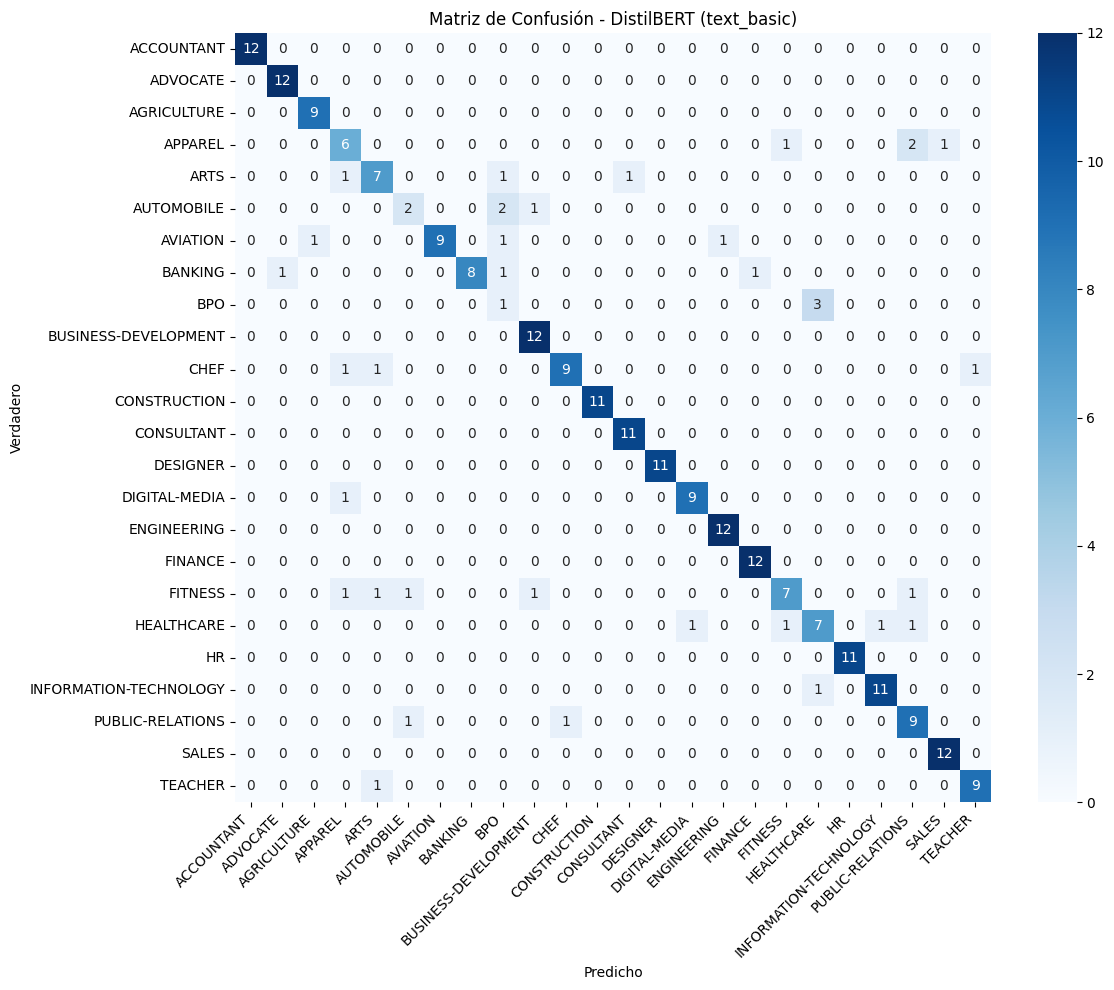

💾 Guardando modelo para text_basic...

✅ Modelo guardado en: ./results_distilbert_basic


🚀 Iniciando entrenamiento para: text_medium con distilbert-base-uncased


░░ PREPARANDO DATOS (SPLIT, ENCODING, PESOS DE CLASE)

Clases detectadas: 24
Mapping de clases: {i: label for i, label in enumerate(label_encoder.classes_)}

░ Dataset: 2621 muestras
   Split: 80% train, 10% val, 10% test

✂️ Dividiendo datos usando Stratified Shuffle Split on unique groups (data leakage prevention and stratification)...
✅ Train: 2104 | Val: 262 | Test: 255

⚖️ Calculando pesos de clase para manejar desbalance...

Pesos por clase (entrenamiento):
  ACCOUNTANT           → peso: 0.933 (n=94)
  ADVOCATE             → peso: 0.933 (n=94)
  AGRICULTURE          → peso: 1.154 (n=76)
  APPAREL              → peso: 1.139 (n=77)
  ARTS                 → peso: 1.056 (n=83)
  AUTOMOBILE           → peso: 1.056 (n=83)
  AVIATION             → peso: 0.943 (n=93)
  BANKING              → peso: 0.953 (n=92)
  BPO           

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Iniciando entrenamiento...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc Ovr
1,2.453000,1.318904,0.763359,0.682926,0.716319,0.945738
2,0.817900,0.681643,0.816794,0.785134,0.811530,0.971330
3,0.465600,0.552709,0.847328,0.820231,0.846180,0.971543
4,0.337700,0.540092,0.832061,0.800637,0.827223,0.975840



✅ Entrenamiento completado


📈 Evaluando en Test Set...



REPORTE DE CLASIFICACIÓN:

                        precision    recall  f1-score   support

            ACCOUNTANT     1.0000    1.0000    1.0000        12
              ADVOCATE     0.8571    1.0000    0.9231        12
           AGRICULTURE     1.0000    1.0000    1.0000         9
               APPAREL     0.7500    0.6000    0.6667        10
                  ARTS     0.7273    0.8000    0.7619        10
            AUTOMOBILE     0.5000    0.4000    0.4444         5
              AVIATION     0.9091    0.8333    0.8696        12
               BANKING     1.0000    0.6364    0.7778        11
                   BPO     0.1429    0.2500    0.1818         4
  BUSINESS-DEVELOPMENT     1.0000    1.0000    1.0000        12
                  CHEF     1.0000    0.7500    0.8571        12
          CONSTRUCTION     1.0000    1.0000    1.0000        11
            CONSULTANT     0.9167    1.0000    0.9565        11
              DESIGNER     1.0000    0.9091    0.9524        11
         DIG

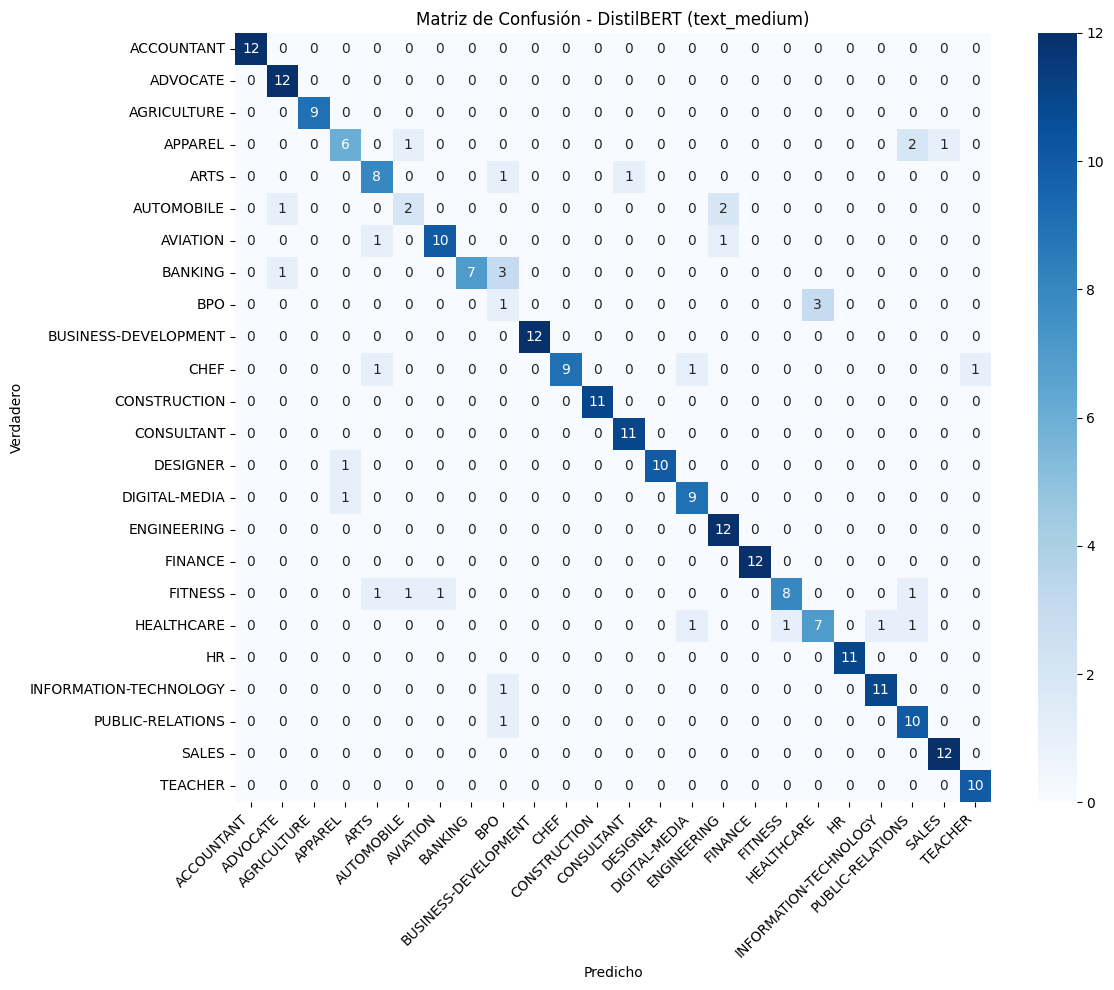

💾 Guardando modelo para text_medium...

✅ Modelo guardado en: ./results_distilbert_medium


🚀 Iniciando entrenamiento para: text_advanced con distilbert-base-uncased


░░ PREPARANDO DATOS (SPLIT, ENCODING, PESOS DE CLASE)

Clases detectadas: 24
Mapping de clases: {i: label for i, label in enumerate(label_encoder.classes_)}

░ Dataset: 2621 muestras
   Split: 80% train, 10% val, 10% test

✂️ Dividiendo datos usando Stratified Shuffle Split on unique groups (data leakage prevention and stratification)...
✅ Train: 2104 | Val: 262 | Test: 255

⚖️ Calculando pesos de clase para manejar desbalance...

Pesos por clase (entrenamiento):
  ACCOUNTANT           → peso: 0.933 (n=94)
  ADVOCATE             → peso: 0.933 (n=94)
  AGRICULTURE          → peso: 1.154 (n=76)
  APPAREL              → peso: 1.139 (n=77)
  ARTS                 → peso: 1.056 (n=83)
  AUTOMOBILE           → peso: 1.056 (n=83)
  AVIATION             → peso: 0.943 (n=93)
  BANKING              → peso: 0.953 (n=92)
  BPO       

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Iniciando entrenamiento...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc Ovr
1,2.599400,1.519539,0.725191,0.641731,0.673622,0.935867
2,0.916900,0.686872,0.839695,0.794155,0.824934,0.961346
3,0.521000,0.559088,0.847328,0.813217,0.843109,0.967022
4,0.375800,0.537871,0.858779,0.827015,0.851828,0.971931



✅ Entrenamiento completado


📈 Evaluando en Test Set...



REPORTE DE CLASIFICACIÓN:

                        precision    recall  f1-score   support

            ACCOUNTANT     1.0000    1.0000    1.0000        12
              ADVOCATE     0.9231    1.0000    0.9600        12
           AGRICULTURE     1.0000    1.0000    1.0000         9
               APPAREL     0.8571    0.6000    0.7059        10
                  ARTS     0.7273    0.8000    0.7619        10
            AUTOMOBILE     0.6667    0.4000    0.5000         5
              AVIATION     0.9167    0.9167    0.9167        12
               BANKING     1.0000    0.7273    0.8421        11
                   BPO     0.2500    0.2500    0.2500         4
  BUSINESS-DEVELOPMENT     0.9231    1.0000    0.9600        12
                  CHEF     0.9000    0.7500    0.8182        12
          CONSTRUCTION     1.0000    1.0000    1.0000        11
            CONSULTANT     0.9091    0.9091    0.9091        11
              DESIGNER     1.0000    0.9091    0.9524        11
         DIG

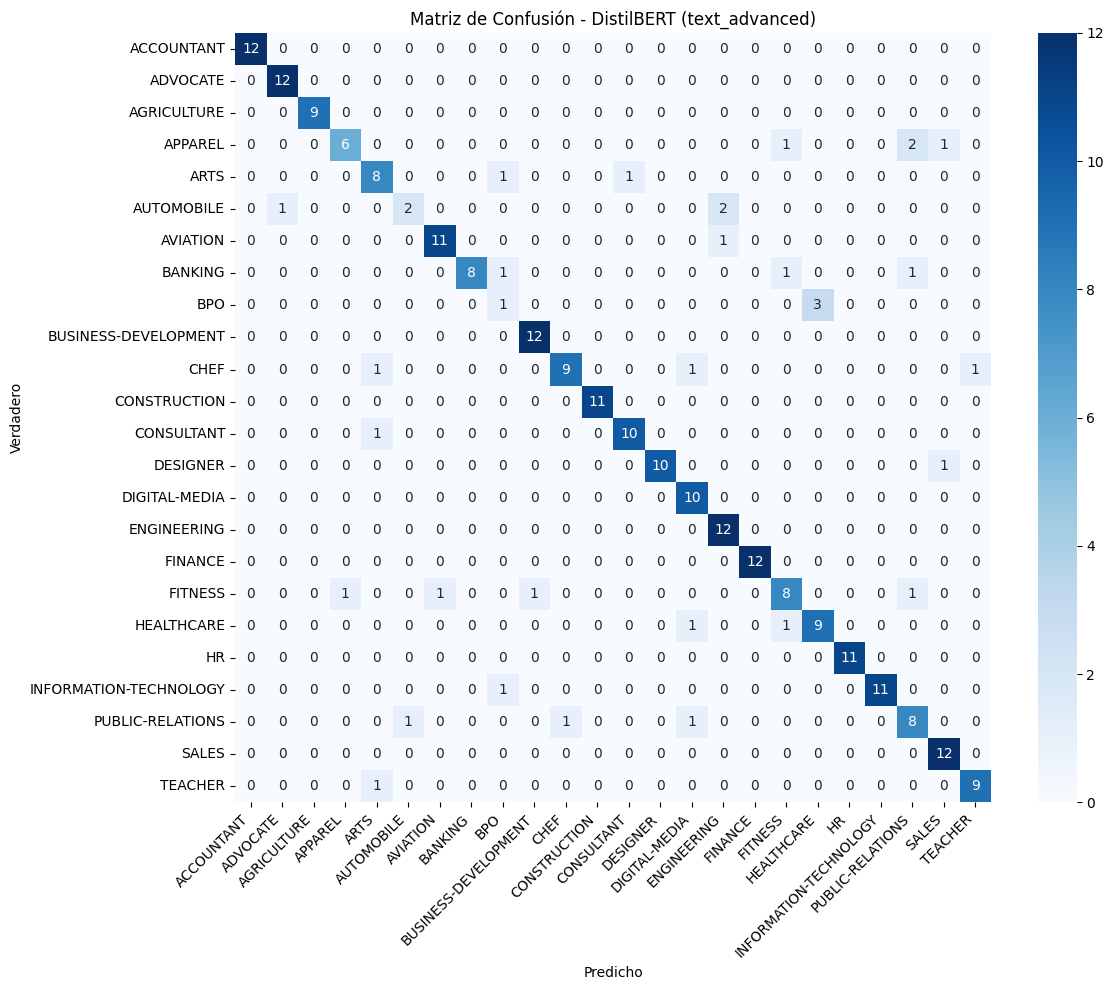

💾 Guardando modelo para text_advanced...

✅ Modelo guardado en: ./results_distilbert_advanced



In [ ]:
#@title bert
training_configs = [
    {
        "text_column": "text_basic",
        "output_dir": "./results_distilbert_basic",
        "plot_title": "Matriz de Confusión - DistilBERT (text_basic)"
    },
    {
        "text_column": "text_medium",
        "output_dir": "./results_distilbert_medium",
        "plot_title": "Matriz de Confusión - DistilBERT (text_medium)"
    },
    {
        "text_column": "text_advanced",
        "output_dir": "./results_distilbert_advanced",
        "plot_title": "Matriz de Confusión - DistilBERT (text_advanced)"
    }
]

MODEL_NAME = "distilbert-base-uncased"
print(f"💻 Dispositivo: {device}")

for config in training_configs:
    text_column = config["text_column"]
    output_dir = config["output_dir"]
    plot_title = config["plot_title"]

    print(f"\n" + '='*70)
    print(f"🚀 Iniciando entrenamiento para: {text_column} con {MODEL_NAME}")
    print(f"" + '='*70 + "\n")

    (X_train, X_val, X_test,
     y_train, y_val, y_test,
     label_encoder, num_labels,
     class_weights_numpy, class_weights_tensor,
     sample_weights_train) = prepare_data_for_training(
        data_for_models, text_column, "Category", device=device, group_ids=original_ids_for_models
    )

    print("📊 ANÁLISIS DE DESBALANCE DE CLASES (Usando datos originales para referencia)\n")
    class_distribution = data_for_models['Category'].value_counts()
    print("\nDistribución de clases (original):\n")
    print(class_distribution)
    imbalance_ratio = class_distribution.max() / class_distribution.min()
    print(f"\n⚠️ Ratio de desbalance: {imbalance_ratio:.2f}x")
    print(f"" + '='*70 + "\n")


    print("🔤 Tokenizando textos...\n")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    def tokenize_data(texts, labels):
        texts_as_list_of_str = [str(t) for t in texts]
        encodings = tokenizer(
            texts_as_list_of_str,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors='pt'
        )
        return encodings, torch.tensor(labels)

    train_encodings, train_labels = tokenize_data(X_train, y_train)
    val_encodings, val_labels = tokenize_data(X_val, y_val)
    test_encodings, test_labels = tokenize_data(X_test, y_test)

    print(f"✅ Tokenización completada")
    print(f"   Longitud máxima: {train_encodings['input_ids'].shape[1]} tokens\n")


    train_dataset = ResumeDataset(train_encodings, train_labels)
    val_dataset = ResumeDataset(val_encodings, val_labels)
    test_dataset = ResumeDataset(test_encodings, test_labels)


    print(f"🦾 Cargando modelo: {MODEL_NAME}...\n")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        problem_type="single_label_classification"
    )

    model.to(device)
    class_weights_tensor = class_weights_tensor.to(device)


    training_args = TrainingArguments(
        output_dir=output_dir,

        num_train_epochs=4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,

        learning_rate=3e-5,
        weight_decay=0.01,
        warmup_ratio=0.1,

        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="roc_auc_ovr",
        greater_is_better=True,

        logging_dir=f'./logs_{text_column}',
        logging_steps=50,
        report_to="none",

        save_total_limit=2,

        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0,
        seed=42
    )


    print("\n🚀 Iniciando entrenamiento...\n")
    print("="*70)

    trainer = WeightedTrainer(
        class_weights=class_weights_tensor,
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_metric="roc_auc_ovr", greater_is_better=True)]
    )

    train_result = trainer.train()

    print("\n✅ Entrenamiento completado\n")
    print("="*70)


    print("\n📈 Evaluando en Test Set...\n")

    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    print("REPORTE DE CLASIFICACIÓN:\n")
    print(classification_report(
        y_test,
        y_pred,
        target_names=label_encoder.classes_,
        digits=4
    ))

    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1_macro = f1_score(y_test, y_pred, average='macro')
    test_f1_weighted = f1_score(y_test, y_pred, average='weighted')

    test_logits = predictions.predictions
    test_probabilities = torch.softmax(torch.from_numpy(test_logits), dim=1).numpy()
    num_labels_test = test_logits.shape[1]
    test_labels_one_hot = np.eye(num_labels_test)[y_test]
    test_roc_auc_ovr = roc_auc_score(test_labels_one_hot, test_probabilities, average='macro', multi_class='ovr')

    print(f"\n" + '='*70)
    print(f"📊 MÉTRICAS FINALES EN TEST ({text_column}):")
    print(f"   • Accuracy: {test_accuracy:.4f}")
    print(f"   • F1-Score (macro): {test_f1_macro:.4f}")
    print(f"   • F1-Score (weighted): {test_f1_weighted:.4f}")
    print(f"   • ROC AUC (OvR): {test_roc_auc_ovr:.4f}")
    print(f"" + '='*70 + "\n")


    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(12, 10))
sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
plt.title(plot_title)
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print(f"💾 Guardando modelo para {text_column}...\n")

    os.makedirs(output_dir, exist_ok=True)

    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    label_encoder_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
    with open(os.path.join(output_dir, "label_mapping.json"), "w") as f:
        json.dump(label_encoder_mapping, f, indent=2)

    print(f"✅ Modelo guardado en: {output_dir}")
    print("\n" + '='*70)


✅ Imports y funciones de limpieza completados

[INFO] Dispositivo: cpu

📊 PREPARACIÓN DE DATOS PARA FASTTEXT SUPERVISADO


✔ Iniciando pipeline de preparacion de datos para modelos...
   [INFO] Google Drive ya montado.

✔ Intentando cargar dataframe aumentado desde Google Drive: /content/drive/MyDrive/data_augmented_processed.csv
✅ Dataframe aumentado cargado desde Google Drive: 2621 filas, 8 columnas.
   ✓ 'text_medium' columna llenada/regenerada para 1 filas.
   ✓ 'text_advanced' columna llenada/regenerada para 1 filas.
   ✀ Total de filas afectadas por la regeneracion de columnas: 2 (Detalles: 'text_medium' (1 nulls), 'text_advanced' (1 nulls))

   ✔ DataFrame actualizado y guardado en Google Drive: /content/drive/MyDrive/data_augmented_processed.csv
✅ Pipeline de preparacion de datos completado.

░░ PREPARANDO DATOS (SPLIT, ENCODING, PESOS DE CLASE)

Clases detectadas: 24
Mapping de clases: {i: label for i, label in enumerate(label_encoder.classes_)}

░ Dataset: 2621 muestras
   Sp

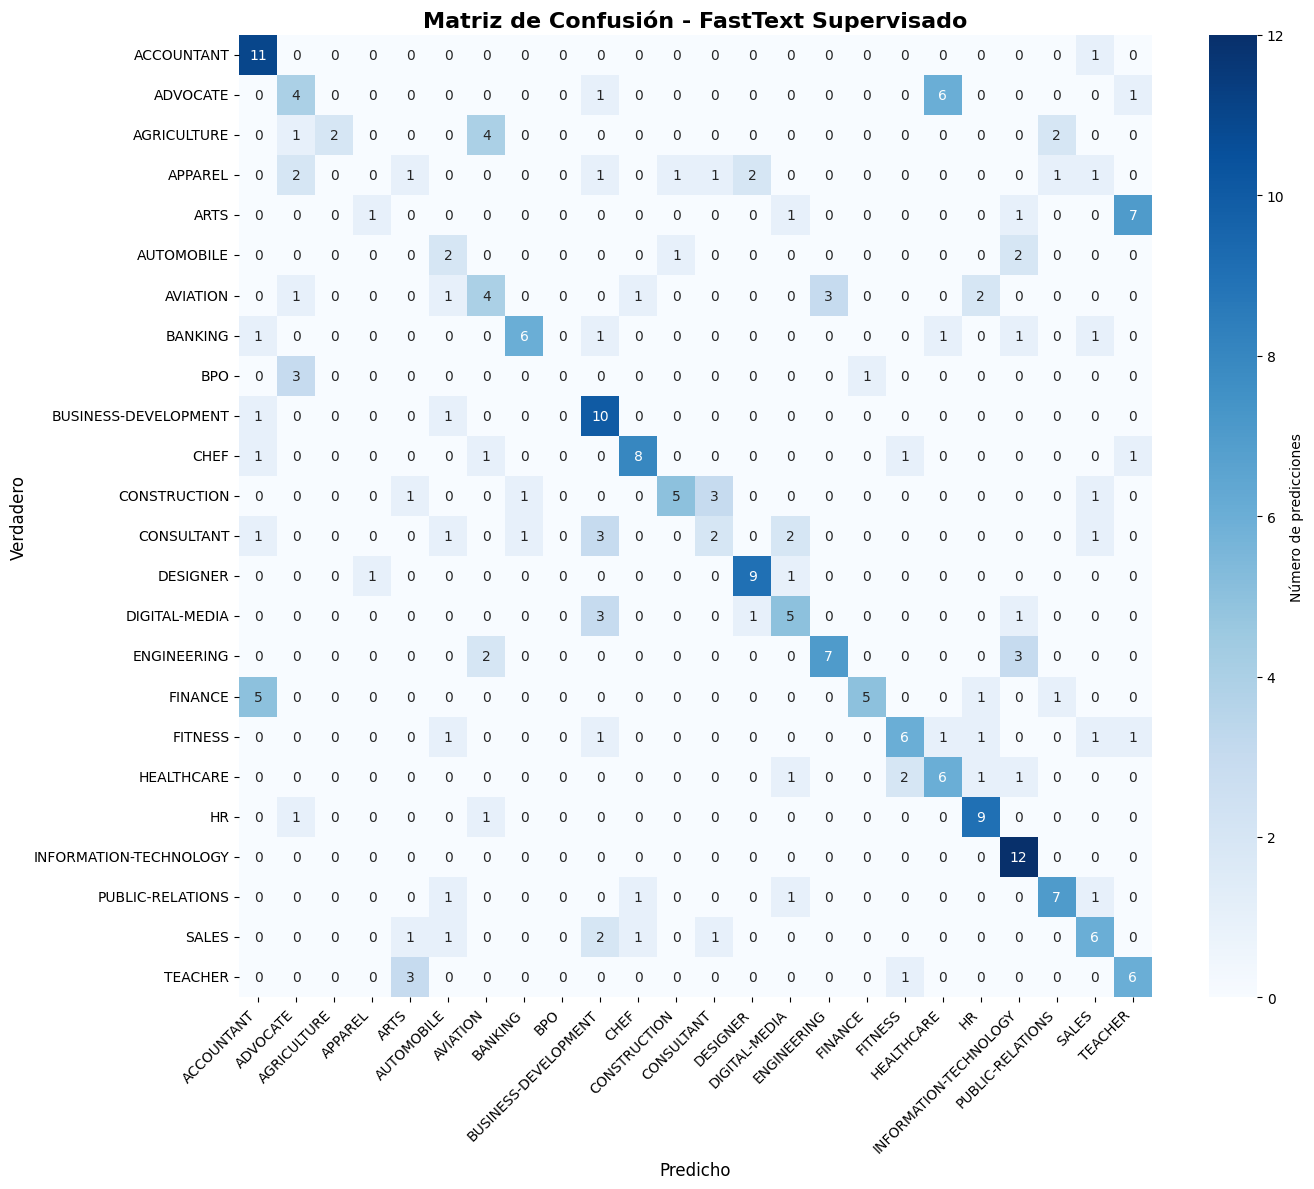


💾 Guardando modelo...

✅ Modelo guardado: fasttext_supervised_model.bin
✅ Label encoder guardado: fasttext_label_encoder.pkl
✅ Configuracion guardada: fasttext_model_config.json
🎉 PROCESO COMPLETADO

📌 Para cargar el modelo posteriormente:
   model = fasttext.load_model('fasttext_supervised_model.bin')
   predictions = model.predict('tu texto aquí', k=3)


In [ ]:
# @title FastText Supervisado - Clasificación Directa (SIN XGBoost)
import os
os.environ["WANDB_DISABLED"] = "true"

import numpy as np
import pandas as pd
import fasttext
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import html

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_level_basic(text):
    if pd.isnull(text):
        return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'－', '-', text).replace('—', '-').replace('–', '-')
    text = re.sub(r'([a-zA-Z])\*([a-zA-Z])', r'\1 \2', text)
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_level_medium(text):
    text = clean_level_basic(text)
    text = text.lower()
    text = re.sub(r'[\W_]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_level_advanced(text):
    text = clean_level_medium(text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    words = [lemmatizer.lemmatize(word, pos='n') for word in words]
    return ' '.join(words)


print("✅ Imports y funciones de limpieza completados\n")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Dispositivo: {device}\n")


print("="*70)
print("📊 PREPARACIÓN DE DATOS PARA FASTTEXT SUPERVISADO")
print("="*70 + "\n")

data_for_models, original_ids_for_models = get_data_for_models()

(X_train, X_val, X_test,
 y_train, y_val, y_test,
 label_encoder, num_classes,
 class_weights_numpy, class_weights_tensor,
 sample_weights_train) = prepare_data_for_training(
    data_for_models, "text_advanced", "Category", device=device, group_ids=original_ids_for_models
)

print(f"📈 Distribución de clases en training:")
train_dist = Counter(y_train)
for cls, count in sorted(train_dist.items()):
    cls_name = label_encoder.classes_[cls]
    print(f"   {cls_name:25s}: {count:4d} ({count/len(y_train)*100:.1f}%)")
print()


print("📝 Preparando archivos en formato FastText...\n")

def preprocess_text(text):
    text = str(text).lower()
    text = text.replace('.', ' . ')
    text = text.replace(',', ' , ')
    text = text.replace('!', ' ! ')
    text = text.replace('?', ' ? ')
    import re
    text = re.sub(r'[^a-záéíóúñü0-9\s\.\,\!\?]', ' ', text)
    text = ' '.join(text.split())
    return text

def create_fasttext_file(texts, labels, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for text, label in zip(texts, labels):
            label_name = label_encoder.classes_[label]
            processed_text = preprocess_text(text)
            f.write(f"__label__{label_name} {processed_text}\n")

print("🔄 Creando archivos .txt...")
create_fasttext_file(X_train, y_train, 'train.txt')
create_fasttext_file(X_val, y_val, 'val.txt')
create_fasttext_file(X_test, y_test, 'test.txt')
print("✅ Archivos creados: train.txt, val.txt, test.txt\n")


print("="*70)
print("🚀 ENTRENAMIENTO FASTTEXT SUPERVISADO")
print("="*70 + "\n")

print("🔄 Entrenando modelo FastText supervisado...")
print("   (Esto puede tomar varios minutos)\n")

model = fasttext.train_supervised(
    input='train.txt',
    dim=500,
    ws=5,
    lr=0.25,
    epoch=200,
    wordNgrams=5,
    minn=2,
    maxn=8,
    loss='ova',
    thread=4,
    lrUpdateRate=100,
    bucket=2000000,
    minCount=1,
    minCountLabel=1,
    verbose=2
)

print("\n✅ Modelo FastText entrenado")
print(f"   Vocabulario: {len(model.words)} palabras")
print(f"   Labels: {len(model.labels)} categorías")
print(f"   Dimensión: 500\n")


print("="*70)
print("📊 EVALUACIÓN EN VALIDATION SET")
print("="*70 + "\n")

n_samples_val, precision_val, recall_val = model.test('val.txt')

print(f"Validation Set (método .test()):\n")
print(f"   Samples:   {n_samples_val}")
print(f"   Precision: {precision_val:.4f}")
print(f"   Recall:    {recall_val:.4f}")
print(f"   F1-score:  {2 * (precision_val * recall_val) / (precision_val + recall_val):.4f}\n")

print("🔄 Generando predicciones detalladas en validation...\n")

def predict_from_file(model, filename, label_encoder):
    texts = []
    true_labels_names = []

    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                true_label_name = parts[0].replace('__label__', '')
                text = parts[1]
                texts.append(text)
                true_labels_names.append(true_label_name)

    num_classes = len(label_encoder.classes_)
    all_pred_labels_names = []
    all_pred_probas_ordered = []

    class_name_to_idx = {name: i for i, name in enumerate(label_encoder.classes_)}

    for text_raw in texts:
        processed_text = preprocess_text(text_raw)

        ft_labels_for_text, ft_probas_for_text = model.predict(processed_text, k=num_classes)

        proba_vector = np.zeros(num_classes)

        for ft_lbl, prob in zip(ft_labels_for_text, ft_probas_for_text):
            clean_lbl = ft_lbl.replace('__label__', '')
            if clean_lbl in class_name_to_idx:
                idx_in_ordered = class_name_to_idx[clean_lbl]
                proba_vector[idx_in_ordered] = prob

        all_pred_probas_ordered.append(proba_vector)

        if ft_labels_for_text:
            top_pred_label_name = ft_labels_for_text[0].replace('__label__', '')
            all_pred_labels_names.append(top_pred_label_name)
        else:
            all_pred_labels_names.append(label_encoder.classes_[0])

    return true_labels_names, all_pred_labels_names, np.array(all_pred_probas_ordered)

y_val_true_names, y_val_pred_names, y_val_pred_probas = predict_from_file(model, 'val.txt', label_encoder)

y_val_true_idx = [list(label_encoder.classes_).index(name) for name in y_val_true_names]
y_val_pred_idx = [list(label_encoder.classes_).index(name) for name in y_val_pred_names]

val_accuracy = accuracy_score(y_val_true_idx, y_val_pred_idx)
val_f1_macro = f1_score(y_val_true_idx, y_val_pred_idx, average='macro', zero_division=0)
val_f1_weighted = f1_score(y_val_true_idx, y_val_pred_idx, average='weighted', zero_division=0)

val_labels_one_hot = np.eye(num_classes)[y_val_true_idx]
val_roc_auc_ovr = roc_auc_score(val_labels_one_hot, y_val_pred_probas, average='macro', multi_class='ovr')

print(f"Métricas detalladas en Validation:\n")
print(f"   Accuracy:    {val_accuracy:.4f}")
print(f"   F1-macro:    {val_f1_macro:.4f}")
print(f"   F1-weighted: {val_f1_weighted:.4f}")
print(f"   ROC AUC (OvR): {val_roc_auc_ovr:.4f}\n")


print("="*70)
print("🧪 EVALUACIÓN EN TEST SET")
print("="*70 + "\n")

n_samples_test, precision_test, recall_test = model.test('test.txt')

print(f"Test Set (método .test()):\n")
print(f"   Samples:   {n_samples_test}")
print(f"   Precision: {precision_test:.4f}")
print(f"   Recall:    {recall_test:.4f}")
print(f"   F1-score:  {2 * (precision_test * recall_test) / (precision_test + recall_test):.4f}\n")

y_test_true_names, y_test_pred_names, y_test_pred_probas = predict_from_file(model, 'test.txt', label_encoder)

y_test_true_idx = [list(label_encoder.classes_).index(name) for name in y_test_true_names]
y_test_pred_idx = [list(label_encoder.classes_).index(name) for name in y_test_pred_names]

test_accuracy = accuracy_score(y_test_true_idx, y_test_pred_idx)
test_f1_macro = f1_score(y_test_true_idx, y_test_pred_idx, average='macro', zero_division=0)
test_f1_weighted = f1_score(y_test_true_idx, y_test_pred_idx, average='weighted', zero_division=0)

test_labels_one_hot = np.eye(num_classes)[y_test_true_idx]
test_roc_auc_ovr = roc_auc_score(test_labels_one_hot, y_test_pred_probas, average='macro', multi_class='ovr')

print(f"📊 MÉTRICAS FINALES EN TEST:\n")
print(f"   Accuracy:    {test_accuracy:.4f}")
print(f"   F1-macro:    {test_f1_macro:.4f}")
print(f"   F1-weighted: {test_f1_weighted:.4f}")
print(f"   ROC AUC (OvR): {test_roc_auc_ovr:.4f}\n")

print(classification_report(
    y_test_true_idx,
    y_test_pred_idx,
    labels=np.arange(num_classes),
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0
))


print("=")*70)
print("📈 MATRIZ DE CONFUSIÓN")
print("="*70 + "\n")
cm = confusion_matrix(y_test_true_idx, y_test_pred_idx, labels=np.arange(num_classes))

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Número de predicciones'})
plt.title('Matriz de Confusión - FastText Supervisado', fontsize=16, fontweight='bold')
plt.ylabel('Verdadero', fontsize=12)
plt.xlabel('Predicho', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("\n💾 Guardando modelo...\n")

model.save_model('fasttext_supervised_model.bin')
print("✅ Modelo guardado: fasttext_supervised_model.bin")

import pickle
with open('fasttext_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder guardado: fasttext_label_encoder.pkl")

import json
config = {
    'model_type': 'fasttext_supervised',
    'dim': 500,
    'ws': 5,
    'lr': 0.25,
    'epoch': 200,
    'wordNgrams': 5,
    'minn': 2,
    'maxn': 8,
    'loss': 'ova',
    'num_classes': num_classes,
    'class_names': label_encoder.classes_.tolist(),
    'test_accuracy': test_accuracy,
    'test_f1_macro': test_f1_macro,
    'test_f1_weighted': test_f1_weighted,
    'test_roc_auc_ovr': test_roc_auc_ovr,
}
with open('fasttext_model_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("✅ Configuracion guardada: fasttext_model_config.json")


print("🎉 PROCESO COMPLETADO")
print("\n📌 Para cargar el modelo posteriormente:")
print("   model = fasttext.load_model('fasttext_supervised_model.bin')")
print("   predictions = model.predict('tu texto aquí', k=3)")